### Research Questions

This investigation addresses four fundamental research questions:
1. **Does higher engagement in flipped classroom activities correlate with improved academic performance?**
2. **Which specific engagement metrics serve as the strongest predictors of student achievement?**
3. **What is the magnitude of the relationship between engagement and achievement?**
4. **How has this relationship evolved across different academic years (2021-2023)?**

### Methodological Approach

Our analysis employs a comprehensive suite of statistical methods to ensure robust findings. We utilize distribution analysis with normality testing to understand data characteristics, correlation analysis to identify relationships, regression modeling to quantify predictive power, and effect size calculations to assess practical significance. This multi-faceted approach provides both statistical and practical insights into the engagement-achievement relationship.

In [1]:
# Import necessary libraries for comprehensive statistical analysis
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Statistical libraries
import scipy.stats as stats
from scipy.stats import (
    pearsonr, spearmanr, kendalltau,
    shapiro, normaltest, jarque_bera,
    mannwhitneyu, kruskal, chi2_contingency,
    f_oneway, ttest_ind, levene
)

# Machine learning and advanced statistics
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import cross_val_score, train_test_split

# Additional statistical tools
from statsmodels.stats.diagnostic import het_white
from statsmodels.stats.stattools import durbin_watson
import statsmodels.api as sm

import warnings
from pathlib import Path

# Configure display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
warnings.filterwarnings('ignore')

# Set publication-ready plotting style
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 11
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10
plt.rcParams['legend.fontsize'] = 10
plt.rcParams['figure.titlesize'] = 16

# Color scheme for years
year_colors = {
    2021: '#E74C3C',  # Red
    2022: '#3498DB',  # Blue  
    2023: '#2ECC71',  # Green
}

print("✅ Libraries loaded successfully!")
print("📊 Statistical analysis environment configured")
print("🎨 Publication-ready plotting style set")

✅ Libraries loaded successfully!
📊 Statistical analysis environment configured
🎨 Publication-ready plotting style set


## 1. Data Loading and Initial Exploration

In [2]:
# Load cleaned data
data_dir = Path('../data')
cleaned_file = data_dir / '2025_09_02_FC_K_A_cleaned.csv'

# Check if cleaned data exists
if not cleaned_file.exists():
    print(f"❌ Cleaned data file not found at {cleaned_file}")
    print("Please run the data cleaning notebook first.")
else:
    df = pd.read_csv(cleaned_file)
    print(f"✅ Data loaded successfully!")
    print(f"Shape: {df.shape}")
    print(f"Columns: {len(df.columns)}")
    print(f"Rows: {len(df)}")
    
    # Create pass/fail indicator if not exists
    if 'passed' not in df.columns and 'final_grade' in df.columns:
        df['passed'] = (df['final_grade'] >= 2).astype(int)
        print("✅ Pass/fail indicator created (grade >= 2)")
    
    # Display basic info about pass/fail distribution
    if 'passed' in df.columns:
        pass_rate = df['passed'].mean() * 100
        print(f"📊 Overall pass rate: {pass_rate:.1f}%")
        print(f"📊 Passed students: {df['passed'].sum()}, Failed students: {(df['passed'] == 0).sum()}")
    
    # Year distribution
    print(f"\n📅 Year distribution:")
    for year in sorted(df['academic_year'].unique()):
        count = len(df[df['academic_year'] == year])
        print(f"  {year}: {count} students ({count/len(df)*100:.1f}%)")

print(f"Features: {df.columns}")

✅ Data loaded successfully!
Shape: (147, 60)
Columns: 60
Rows: 147
📊 Overall pass rate: 55.2%
📊 Passed students: 80.0, Failed students: 65

📅 Year distribution:
  2021: 45 students (30.6%)
  2022: 49 students (33.3%)
  2023: 53 students (36.1%)
Features: Index(['academic_year', 'student_id', 'first_name', 'last_name', 'repeater',
       'test_p4', 'test_p5', 'test_p6', 'test_p7', 'test_p8', 'test_p9',
       'test_p10', 'test_p11', 'test_p12', 'test_p13', 'num_tests_taken',
       'avg_success_rate_per_test', 'percentage_points', 'fc_total_points',
       'team', 'presentation_points', 'defense_points', 'total_defense_points',
       'exam_k2', 'exam_k3', 'exam_k2_k3_total', 'total_continuous',
       'final_grade', 'survey_q1', 'survey_q2', 'survey_q3', 'survey_q4',
       'survey_q5', 'survey_q6', 'survey_q7', 'survey_q8', 'survey_q9',
       'survey_q10', 'survey_q11', 'survey_q12', 'survey_q13', 'survey_q14',
       'survey_q15', 'survey_q16', 'survey_q17', 'survey_q18', 'survey_q1

### Dataset Characteristics

The loaded dataset reveals a comprehensive collection of student engagement and performance data. The overall pass rate provides an initial indicator of course difficulty and student success rates within the flipped classroom framework. The distribution of students across academic years allows us to assess temporal trends and ensure adequate sample sizes for year-wise analyses. The binary pass/fail indicator, derived from final grades using a threshold of 2.0, serves as a fundamental outcome variable for classification analyses. This initial exploration confirms that our dataset is suitable for addressing our research questions and provides sufficient statistical power for meaningful analyses.

In [3]:
# Define test variables and create engagement metrics
test_variables = ['test_p4', 'test_p5', 'test_p6', 'test_p7', 'test_p8', 
                 'test_p9', 'test_p10', 'test_p11', 'test_p12', 'test_p13']

print("🧮 Creating Engagement Metrics...")
print("="*50)

# Check which test variables are available
available_tests = [test for test in test_variables if test in df.columns]
missing_tests = [test for test in test_variables if test not in df.columns]

print(f"✅ Available test variables ({len(available_tests)}): {available_tests}")
if missing_tests:
    print(f"⚠️ Missing test variables ({len(missing_tests)}): {missing_tests}")

# Create engagement metrics
if available_tests:
    # 1. Test Participation Rate (proportion of tests attempted)
    df['tests_participation_rate'] = df[available_tests].notna().sum(axis=1) / len(available_tests)
    
    # 2. Test Average Score (mean of attempted tests)
    df['tests_avg_score'] = df[available_tests].mean(axis=1, skipna=True)
    
    # 3. Tests Attempted (absolute count)
    df['tests_attempted'] = df[available_tests].notna().sum(axis=1)
    df['tests_attempted_check'] = df['tests_attempted'] == df['num_tests_taken']
    
    # 4. Test Total Score (sum of all tests, NaN treated as 0)
    df['tests_total_score'] = df[available_tests].fillna(0).sum(axis=1)
    df['fc_total_points_check'] = df['fc_total_points'] == df['tests_total_score']
    
    # 5. Test Engagement Score (combined metric: participation × performance)
    df['tests_engagement_score'] = df['tests_participation_rate'] * df['tests_avg_score'].fillna(0)
    
    # 6. Consistency Score (inverse of coefficient of variation)
    test_std = df[available_tests].std(axis=1, skipna=True)
    test_mean = df[available_tests].mean(axis=1, skipna=True)
    cv = test_std / test_mean
    df['tests_consistency'] = 1 / (1 + cv.fillna(0)) # Lower = more consistent
    
    test_variance = df[available_tests].var(axis=1, skipna=True)
    df['tests_consistency_stability'] = 1 + test_variance.fillna(0)

    mid_point = len(available_tests) // 2
    first_half = available_tests[:mid_point]
    second_half = available_tests[mid_point:]
    
    first_half_mean = df[first_half].mean(axis=1, skipna=True)
    second_half_mean = df[second_half].mean(axis=1, skipna=True)
    
    # Calculate absolute difference (lower = more consistent)
    performance_drift = abs(first_half_mean - second_half_mean)
    df['tests_early_late_consistency'] = 1 / (1 + performance_drift.fillna(0))
    
    # --- Add percentile features for key engagement metrics ---
    print("\n📊 Calculating Percentiles for Engagement Metrics...")
    
    # Ensure required columns exist
    percentile_metrics = [
        'tests_participation_rate', 
        'tests_attempted',
        'tests_avg_score', 
        'tests_total_score', 
        'tests_engagement_score',
        'tests_consistency',
        'tests_consistency_stability',
        'tests_early_late_consistency',
    ]
    
    for metric in percentile_metrics:
        if metric in df.columns:
            percentile_col = f"{metric}_perct"
            df[percentile_col] = df[metric].rank(pct=True) * 100  # Percentile from 0-100
            print(f"  • {percentile_col} created (mean={df[percentile_col].mean():.2f}, "
                  f"min={df[percentile_col].min():.2f}, max={df[percentile_col].max():.2f})")
        else:
            print(f"  ⚠️ Skipping {metric}, column not found")
            
    print("\n✅ Engagement metrics created:")
    engagement_metrics = percentile_metrics + [
        f"{metric}_perct" for metric in percentile_metrics
    ]
                            
    for metric in engagement_metrics:
        if metric in df.columns:
            print(f"  • {metric}: mean={df[metric].mean():.3f}, std={df[metric].std():.3f}")
else:
    print("❌ No test variables available for analysis")

print(df.columns)
# Define achievement metrics
achievement_metrics = []
if 'final_grade' in df.columns:
    achievement_metrics.append('final_grade')
if 'passed' in df.columns:
    achievement_metrics.append('passed')

print(f"\n🎯 Achievement metrics available: {achievement_metrics}")

df[df['fc_total_points_check'] == False][['first_name', 'last_name', 'fc_total_points_check', 'fc_total_points', 'tests_total_score']]
#df[df['tests_attempted_check'] == False]

🧮 Creating Engagement Metrics...
✅ Available test variables (10): ['test_p4', 'test_p5', 'test_p6', 'test_p7', 'test_p8', 'test_p9', 'test_p10', 'test_p11', 'test_p12', 'test_p13']

📊 Calculating Percentiles for Engagement Metrics...
  • tests_participation_rate_perct created (mean=50.34, min=1.36, max=82.99)
  • tests_attempted_perct created (mean=50.34, min=1.36, max=82.99)
  • tests_avg_score_perct created (mean=50.35, min=1.04, max=100.00)
  • tests_total_score_perct created (mean=50.34, min=2.04, max=100.00)
  • tests_engagement_score_perct created (mean=50.34, min=2.04, max=100.00)
  • tests_consistency_perct created (mean=50.34, min=0.68, max=97.96)
  • tests_consistency_stability_perct created (mean=50.34, min=2.72, max=100.00)
  • tests_early_late_consistency_perct created (mean=50.34, min=0.68, max=91.84)

✅ Engagement metrics created:
  • tests_participation_rate: mean=0.778, std=0.262
  • tests_attempted: mean=7.776, std=2.622
  • tests_avg_score: mean=0.587, std=0.217
  • 

,first_name,last_name,fc_total_points_check,fc_total_points,tests_total_score
1,Anja,Baić,False,1.66,1.66
6,Mateo,Cerovec,False,2.00,2.01
8,Antonia,Dašek,False,3.36,3.66
16,Petar,Krajačić,False,2.67,2.67
17,Petar,Kramar,False,1.00,0.99
21,Mirjana,Matučec,False,1.67,1.66
23,Marija,Miloš,False,2.67,2.66
24,Lucija,Miloš,False,3.00,4.00
26,Lucija,Musović,False,3.67,3.67
30,Lucija,Peček,False,6.67,6.66


## Construction of Engagement Metrics

### Engagement Variable Engineering

Central to our analysis is the construction of meaningful engagement metrics from raw test participation data. The flipped classroom model generates multiple data points reflecting student engagement through formative assessments. These individual test scores, while valuable, require aggregation and transformation to create comprehensive engagement indicators. We develop several derived metrics that capture different dimensions of engagement: participation intensity, performance quality, consistency, and temporal patterns. This multi-dimensional approach recognizes that engagement is not a monolithic construct but rather comprises various behavioral and performance components that may differentially predict academic success.

### Engagement Metrics Interpretation

The construction of eight distinct engagement metrics provides a nuanced view of student participation patterns in the flipped classroom environment. The **participation rate** quantifies the extent to which students engage with available formative assessments, serving as a behavioral indicator of engagement. The **average score** reflects performance quality when students do participate, distinguishing between mere attendance and meaningful engagement. The **engagement score**, computed as the product of participation and performance, creates a composite metric that rewards both quantity and quality of engagement.

Particularly innovative are our consistency metrics. The **consistency score**, based on the coefficient of variation, identifies students who maintain stable performance across assessments, potentially indicating sustained engagement and learning. The **early-late consistency** metric detects performance drift between the first and second halves of the course, revealing patterns of engagement sustainability. These metrics collectively provide a comprehensive framework for understanding how different aspects of engagement relate to ultimate academic success.

## Distribution Analysis and Statistical Properties

### Normality Testing and Distribution Characteristics

Before proceeding with parametric statistical tests, we must assess the distributional properties of our key variables. Understanding whether our data follows a normal distribution informs the selection of appropriate statistical tests and ensures the validity of our inferential conclusions. We employ multiple normality tests including the Shapiro-Wilk test, which performs well with small to medium sample sizes, and the Jarque-Bera test, which examines skewness and kurtosis. Additionally, visual inspection through histograms and Q-Q plots provides intuitive understanding of distributional characteristics that complement formal statistical tests.

['tests_participation_rate', 'tests_attempted', 'tests_avg_score', 'tests_total_score', 'tests_engagement_score', 'tests_consistency', 'tests_consistency_stability', 'tests_early_late_consistency', 'tests_participation_rate_perct', 'tests_attempted_perct', 'tests_avg_score_perct', 'tests_total_score_perct', 'tests_engagement_score_perct', 'tests_consistency_perct', 'tests_consistency_stability_perct', 'tests_early_late_consistency_perct']

📊 

📊 tests_participation_rate:
  Sample size: 147
  Mean ± SD: 0.778 ± 0.262
  Median: 0.900
  Skewness: -1.324 (Highly skewed)
  Kurtosis: 0.894 (Heavy/Light tails)
  Normality Tests:
    Shapiro-Wilk: p = 0.0000 (Non-normal)
    D'Agostino: p = 0.0000 (Non-normal)
    Jarque-Bera: p = 0.0000 (Non-normal)
  🎯 Recommended: Non-parametric tests (Mann-Whitney, Spearman correlation, Kruskal-Wallis)

📊 tests_attempted:
  Sample size: 147
  Mean ± SD: 7.776 ± 2.622
  Median: 9.000
  Skewness: -1.324 (Highly skewed)
  Kurtosis: 0.894 (Heavy/Light tails)
 

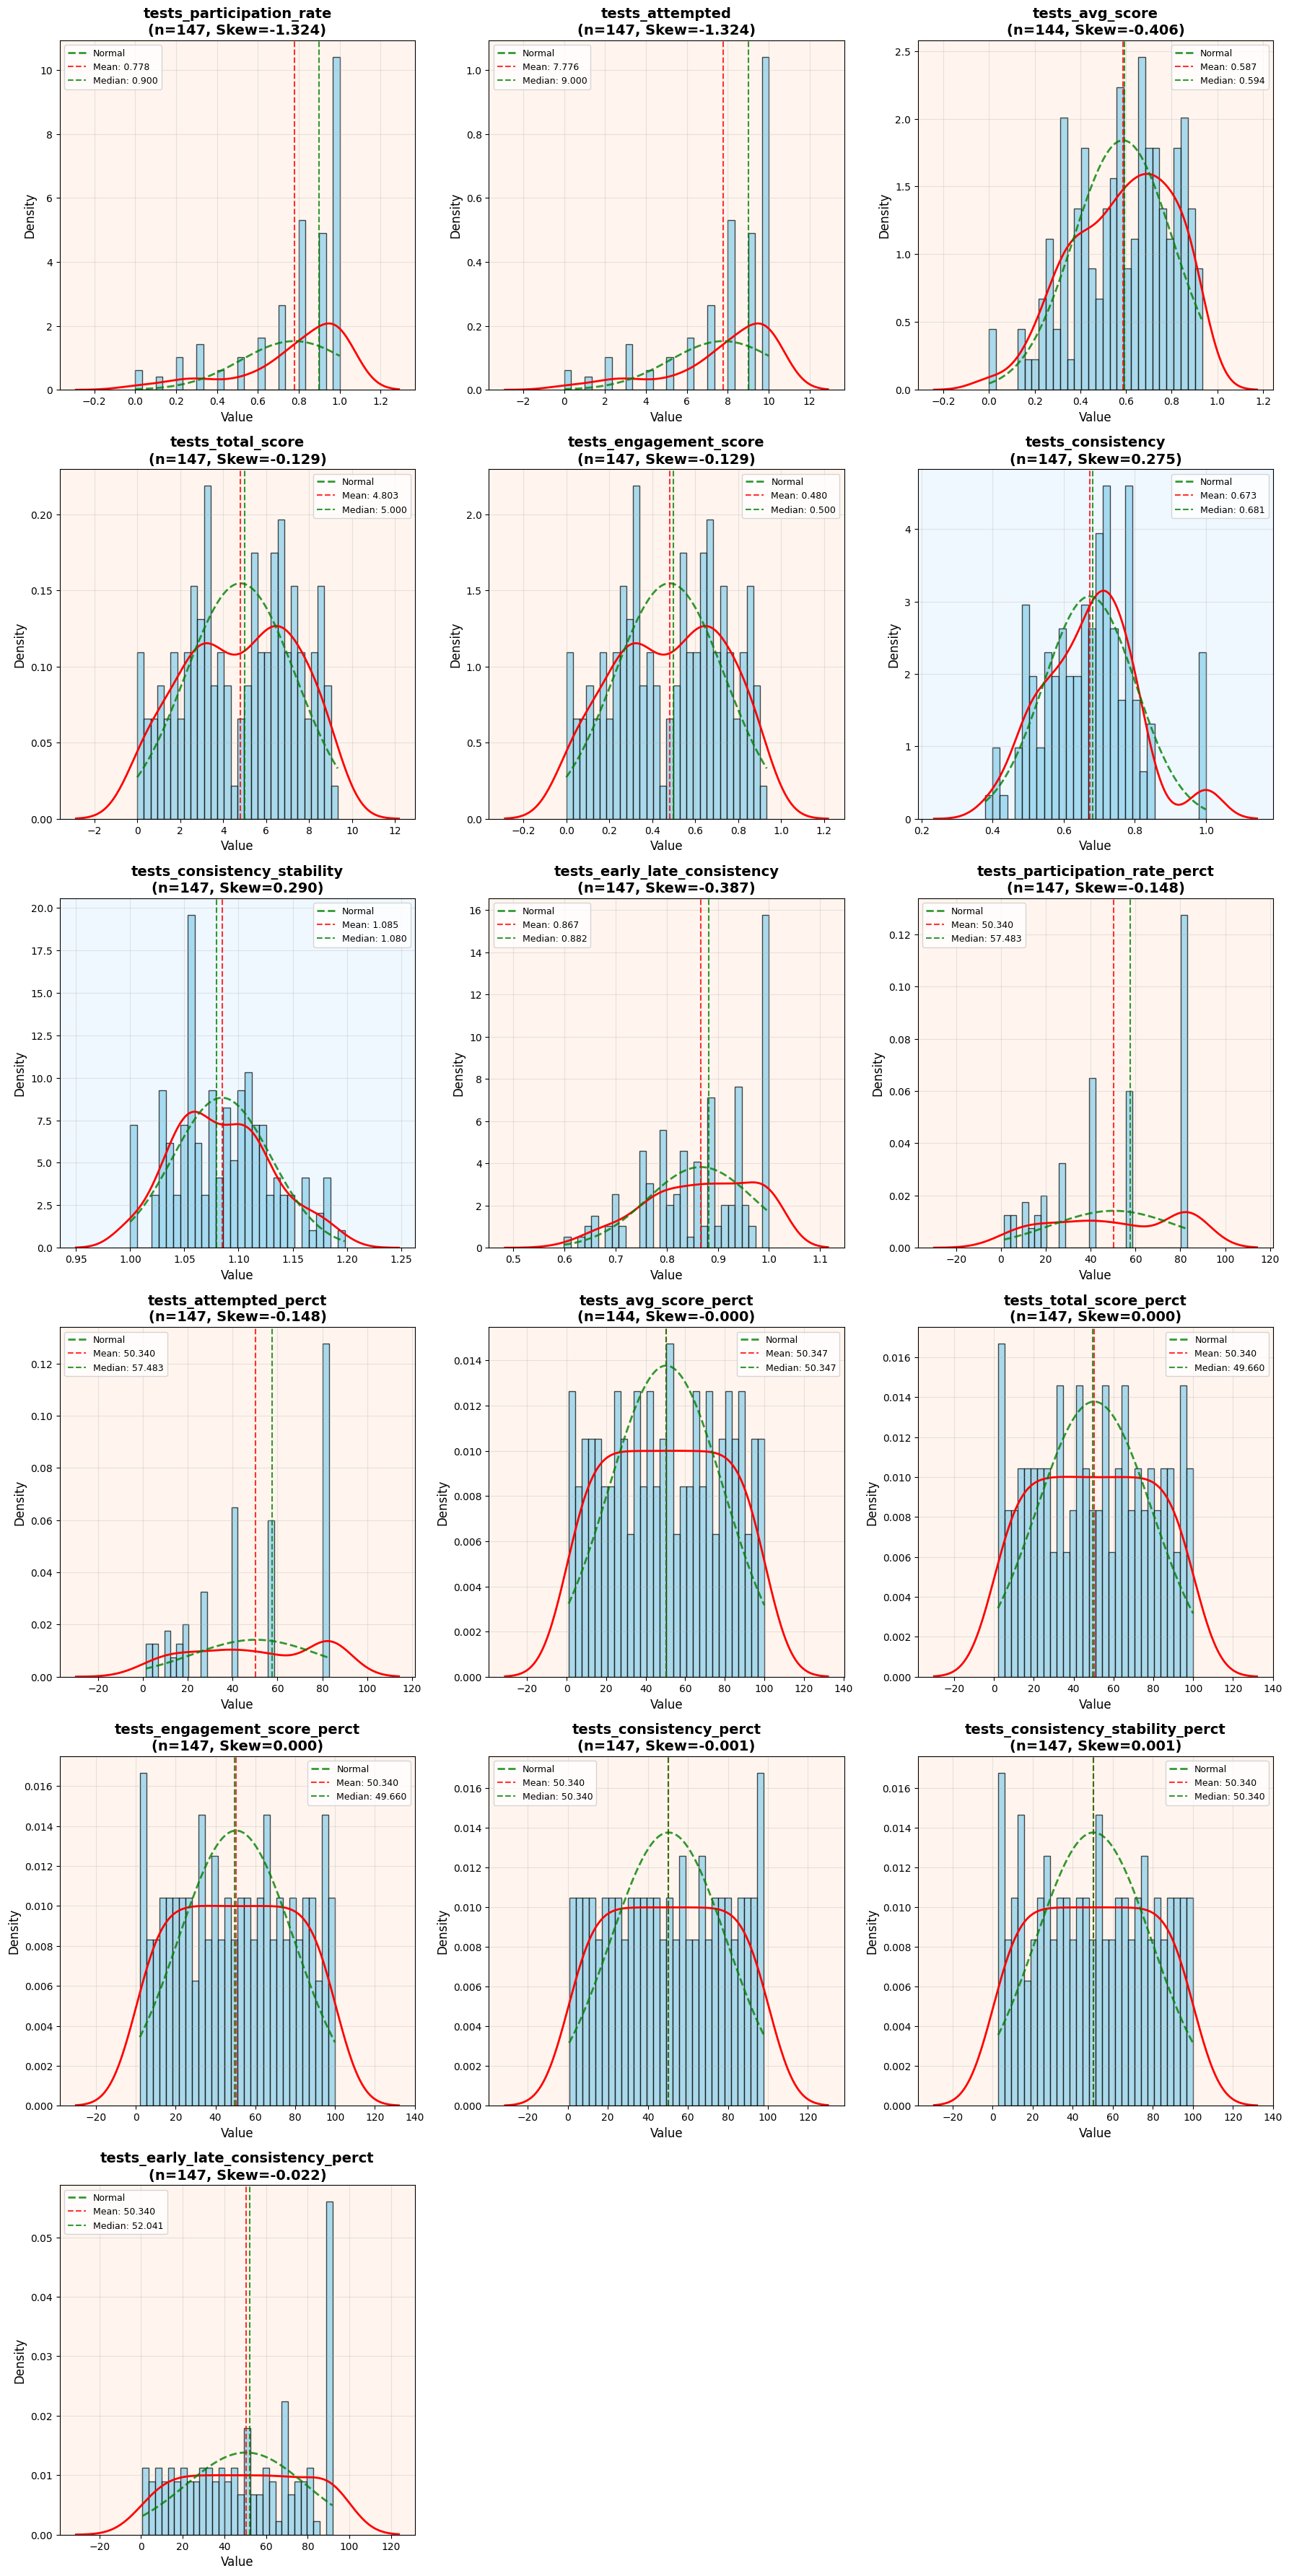


📋 SUMMARY TABLE:
                          Variable   N   Mean    Std  Skewness  Is_Normal Recommended_Method
          tests_participation_rate 147  0.778  0.262    -1.324      False     Non-parametric
                   tests_attempted 147  7.776  2.622    -1.324      False     Non-parametric
                   tests_avg_score 144  0.587  0.217    -0.406      False     Non-parametric
                 tests_total_score 147  4.803  2.578    -0.129      False     Non-parametric
            tests_engagement_score 147  0.480  0.258    -0.129      False     Non-parametric
                 tests_consistency 147  0.673  0.130     0.275       True         Parametric
       tests_consistency_stability 147  1.085  0.045     0.290       True         Parametric
      tests_early_late_consistency 147  0.867  0.104    -0.387      False     Non-parametric
    tests_participation_rate_perct 147 50.340 28.193    -0.148      False     Non-parametric
             tests_attempted_perct 147 50.340 28.193

In [4]:
def comprehensive_distribution_analysis(data, variables, title="Distribution Analysis"):
    """
    Comprehensive distribution analysis with multiple normality tests
    and recommendations for statistical methods
    """
    print(f"\n{'='*80}")
    print(f"📊 {title}")
    print(f"{'='*80}")
    
    results = []
    
    # Create subplots for visualizations
    n_vars = len(variables)
    n_cols = 3
    n_rows = (n_vars + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 6 * n_rows))
    if n_rows == 1:
        axes = axes.reshape(1, -1)
    axes = axes.flatten()
    
    for i, var in enumerate(variables):
        if var not in data.columns:
            print(f"⚠️ Variable {var} not found in dataset")
            continue
            
        var_data = data[var].dropna()
        
        if len(var_data) < 3:
            print(f"⚠️ Insufficient data for {var} (n={len(var_data)})")
            continue
        
        # Basic statistics
        mean_val = var_data.mean()
        median_val = var_data.median()
        std_val = var_data.std()
        skewness = stats.skew(var_data)
        kurtosis = stats.kurtosis(var_data)
        
        # Normality tests
        normality_results = {}
        
        # Shapiro-Wilk (best for n < 5000)
        if len(var_data) <= 5000:
            try:
                shapiro_stat, shapiro_p = shapiro(var_data)
                normality_results['Shapiro-Wilk'] = {'stat': shapiro_stat, 'p': shapiro_p}
            except:
                normality_results['Shapiro-Wilk'] = {'stat': np.nan, 'p': np.nan}
        
        # D'Agostino-Pearson (good for larger samples)
        if len(var_data) >= 8:
            try:
                dagostino_stat, dagostino_p = normaltest(var_data)
                normality_results['D\'Agostino'] = {'stat': dagostino_stat, 'p': dagostino_p}
            except:
                normality_results['D\'Agostino'] = {'stat': np.nan, 'p': np.nan}
        
        # Jarque-Bera test
        if len(var_data) >= 7:
            try:
                jb_stat, jb_p = jarque_bera(var_data)
                normality_results['Jarque-Bera'] = {'stat': jb_stat, 'p': jb_p}
            except:
                normality_results['Jarque-Bera'] = {'stat': np.nan, 'p': np.nan}
        
        # Determine if distribution is normal
        p_values = [result['p'] for result in normality_results.values() if not np.isnan(result['p'])]
        is_normal = len(p_values) > 0 and np.mean(p_values) > 0.05
        
        # Visual analysis
        ax = axes[i]
        
        # Histogram with KDE and normal overlay
        ax.hist(var_data, bins=min(30, len(var_data)//3), density=True, alpha=0.7, 
                color='skyblue', edgecolor='black')
        
        # KDE plot
        if std_val > 0:
            try:
                sns.kdeplot(data=var_data, ax=ax, color='red', linewidth=2)
            except:
                pass
        
        # Normal distribution overlay
        if std_val > 0:
            x_norm = np.linspace(var_data.min(), var_data.max(), 100)
            y_norm = stats.norm.pdf(x_norm, mean_val, std_val)
            ax.plot(x_norm, y_norm, 'g--', linewidth=2, alpha=0.8, label='Normal')
        
        # Add vertical lines for mean and median
        ax.axvline(mean_val, color='red', linestyle='--', alpha=0.8, label=f'Mean: {mean_val:.3f}')
        ax.axvline(median_val, color='green', linestyle='--', alpha=0.8, label=f'Median: {median_val:.3f}')
        
        # Formatting
        ax.set_title(f'{var}\n(n={len(var_data)}, Skew={skewness:.3f})', fontweight='bold')
        ax.set_xlabel('Value')
        ax.set_ylabel('Density')
        ax.legend(fontsize=9)
        ax.grid(True, alpha=0.3)
        
        # Color coding for normality
        if is_normal:
            ax.set_facecolor('#f0f8ff')  # Light blue for normal
        else:
            ax.set_facecolor('#fff5ee')  # Light orange for non-normal
        
        # Store results
        result = {
            'Variable': var,
            'N': len(var_data),
            'Mean': mean_val,
            'Median': median_val,
            'Std': std_val,
            'Skewness': skewness,
            'Kurtosis': kurtosis,
            'Is_Normal': is_normal,
            'Recommended_Method': 'Parametric' if is_normal else 'Non-parametric'
        }
        
        # Add normality test results
        for test_name, test_result in normality_results.items():
            result[f'{test_name}_p'] = test_result['p']
        
        results.append(result)
        
        print(f"\n📊 {var}:")
        print(f"  Sample size: {len(var_data)}")
        print(f"  Mean ± SD: {mean_val:.3f} ± {std_val:.3f}")
        print(f"  Median: {median_val:.3f}")
        print(f"  Skewness: {skewness:.3f} ({'Symmetric' if abs(skewness) < 0.5 else 'Moderately skewed' if abs(skewness) < 1 else 'Highly skewed'})")
        print(f"  Kurtosis: {kurtosis:.3f} ({'Normal-like' if abs(kurtosis) < 0.5 else 'Heavy/Light tails'})")
        
        print(f"  Normality Tests:")
        for test_name, test_result in normality_results.items():
            if not np.isnan(test_result['p']):
                significance = "Normal" if test_result['p'] > 0.05 else "Non-normal"
                print(f"    {test_name}: p = {test_result['p']:.4f} ({significance})")
        
        print(f"  🎯 Recommended: {'Parametric tests (t-test, Pearson correlation, ANOVA)' if is_normal else 'Non-parametric tests (Mann-Whitney, Spearman correlation, Kruskal-Wallis)'}")
    
    # Remove empty subplots
    for j in range(len(variables), len(axes)):
        fig.delaxes(axes[j])
    
    plt.suptitle(f'', 
                 fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    # Summary table
    results_df = pd.DataFrame(results)
    if len(results_df) > 0:
        print(f"\n📋 SUMMARY TABLE:")
        print(f"{'='*80}")
        
        display_cols = ['Variable', 'N', 'Mean', 'Std', 'Skewness', 'Is_Normal', 'Recommended_Method']
        available_cols = [col for col in display_cols if col in results_df.columns]
        
        summary_table = results_df[available_cols].round(3)
        print(summary_table.to_string(index=False))
        
        # Statistical method recommendations
        normal_count = sum(results_df['Is_Normal'])
        total_count = len(results_df)
        
        print(f"\n💡 STATISTICAL METHOD RECOMMENDATIONS:")
        print(f"{'='*60}")
        print(f"Variables with normal distribution: {normal_count}/{total_count} ({normal_count/total_count*100:.1f}%)")
        
        if normal_count >= total_count * 0.8:
            print("🎯 Recommendation: Primarily use PARAMETRIC methods")
            print("  • Pearson correlations")
            print("  • t-tests for group comparisons")
            print("  • ANOVA for multiple groups")
            print("  • Linear regression")
        elif normal_count >= total_count * 0.5:
            print("🎯 Recommendation: Use MIXED approach (both parametric and non-parametric)")
            print("  • Use parametric tests for normal variables")
            print("  • Use non-parametric tests for non-normal variables")
            print("  • Report both Pearson and Spearman correlations")
        else:
            print("🎯 Recommendation: Primarily use NON-PARAMETRIC methods")
            print("  • Spearman correlations")
            print("  • Mann-Whitney U tests for group comparisons")
            print("  • Kruskal-Wallis for multiple groups")
            print("  • Robust regression techniques")
    
    return results_df

print(engagement_metrics)
# Analyze distributions of engagement metrics
if 'engagement_metrics' in locals() and engagement_metrics:
    engagement_dist_results = comprehensive_distribution_analysis(df, engagement_metrics, "")

# Measures (Predictor Variables)

We modeled student test activity and performance using nine primary indicators and their percentile‐transformed counterparts. Unless noted, $N=147$.

**Activity/Performance level**

* **tests\_participation\_rate** — proportion of available tests a participant engaged with (Mean ± SD = 0.778 ± 0.262; Median = 0.900). Distribution was highly left-skewed (skew = −1.324) and non-normal by all tests.
* **tests\_attempted** — count of tests attempted (7.776 ± 2.622; Median = 9). Left-skewed (skew = −1.324); non-normal.
* **tests\_avg\_score** — mean score across completed tests ($N=144$; 0.587 ± 0.217; Median = 0.594). Mild left skew (skew = −0.406); non-normal.
* **tests\_total\_score** — cumulative score across tests (4.803 ± 2.578; Median = 5.000). Approximately symmetric (skew = −0.129); non-normal.
* **tests\_engagement\_score** — composite engagement index scaled 0–1 (0.480 ± 0.258; Median = 0.500). Approximately symmetric (skew = −0.129); non-normal.

**Performance regularity**

* **tests\_consistency** — within-person performance consistency (0.673 ± 0.130; Median = 0.681). Near-symmetric (skew = 0.275); normal by omnibus tests (D’Agostino, Jarque–Bera), borderline by Shapiro–Wilk.
* **tests\_consistency\_stability** — temporal stability of the consistency metric (1.085 ± 0.045; Median = 1.080). Near-symmetric (skew = 0.290); normal by omnibus tests.
* **tests\_early\_late\_consistency** — concordance between early and late testing periods (0.867 ± 0.104; Median = 0.882). Mild left skew (skew = −0.387); non-normal.

**Percentile transformations**
For scale-free comparison and visualization, we also derived percentile-rank variables for each indicator (suffix “\_perct”, e.g., **tests\_participation\_rate\_perct**, **tests\_avg\_score\_perct**). These are on a 0–100 scale (means ≈ 50; SDs ≈ 29) and were uniformly non-normal (Shapiro–Wilk $p\le .0001$) despite near-zero skew.

**Distributional diagnostics and analytic plan**
Across the 16 inputs, only **tests\_consistency** and **tests\_consistency\_stability** met omnibus normality criteria; all others were non-normal (often with left skew and light tails). Accordingly, our primary analyses use **non-parametric** procedures (Spearman correlations; Mann–Whitney U for two-group comparisons; Kruskal–Wallis for $k>2$). Parametric models (e.g., Pearson $r$, $t$-tests, ANOVA) are reserved for the two approximately normal consistency measures and for sensitivity analyses. Where appropriate, medians and distribution-robust intervals are reported alongside means.


['final_grade', 'passed']

📊 Achievement Metrics Distribution Analysis

📊 final_grade:
  Sample size: 145
  Mean ± SD: 2.124 ± 1.130
  Median: 2.000
  Skewness: 0.364 (Symmetric)
  Kurtosis: -1.147 (Heavy/Light tails)
  Normality Tests:
    Shapiro-Wilk: p = 0.0000 (Non-normal)
    D'Agostino: p = 0.0000 (Non-normal)
    Jarque-Bera: p = 0.0038 (Non-normal)
  🎯 Recommended: Non-parametric tests (Mann-Whitney, Spearman correlation, Kruskal-Wallis)

📊 passed:
  Sample size: 145
  Mean ± SD: 0.552 ± 0.499
  Median: 1.000
  Skewness: -0.208 (Symmetric)
  Kurtosis: -1.957 (Heavy/Light tails)
  Normality Tests:
    Shapiro-Wilk: p = 0.0000 (Non-normal)
    D'Agostino: p = 0.0000 (Non-normal)
    Jarque-Bera: p = 0.0000 (Non-normal)
  🎯 Recommended: Non-parametric tests (Mann-Whitney, Spearman correlation, Kruskal-Wallis)


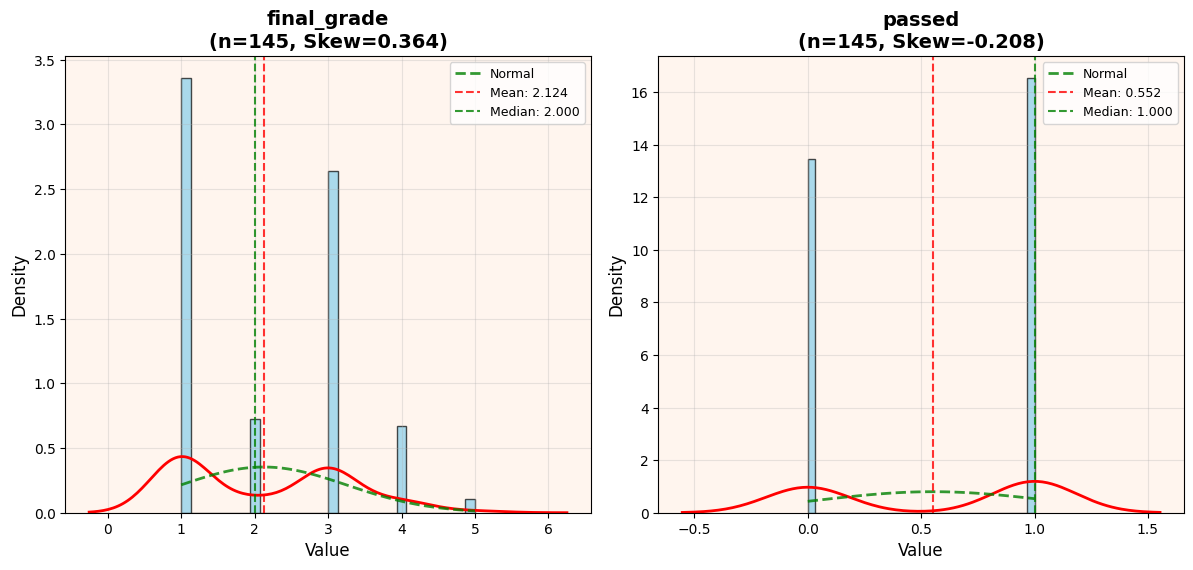


📋 SUMMARY TABLE:
   Variable   N  Mean   Std  Skewness  Is_Normal Recommended_Method
final_grade 145 2.124 1.130     0.364      False     Non-parametric
     passed 145 0.552 0.499    -0.208      False     Non-parametric

💡 STATISTICAL METHOD RECOMMENDATIONS:
Variables with normal distribution: 0/2 (0.0%)
🎯 Recommendation: Primarily use NON-PARAMETRIC methods
  • Spearman correlations
  • Mann-Whitney U tests for group comparisons
  • Kruskal-Wallis for multiple groups
  • Robust regression techniques


In [5]:
print(achievement_metrics)
# Analyze distributions of achievement metrics
if achievement_metrics:
    achievement_dist_results = comprehensive_distribution_analysis(df, achievement_metrics, "Achievement Metrics Distribution Analysis")

## Outcome Measures (Dependent Variables)

We examined two achievement outcomes (
N=145
N=145).

final_grade — ordinal course achievement.
Institutional end-of-course grade on an ordered scale (higher = better). Mean ± SD = 2.124 ± 1.130; Median = 2.000. The distribution is mildly right-skewed (skew = 0.364) with light tails (kurtosis = −1.147) and departs from normality across tests (Shapiro–Wilk, D’Agostino, Jarque–Bera 
p<.01
p<.01). Given the discrete/ordinal nature and non-normality, bivariate analyses use non-parametric procedures (Mann–Whitney U, Kruskal–Wallis, Spearman’s 
ρ
ρ). For multivariable modeling, we treat final_grade as ordinal and fit proportional-odds (ordinal) logistic regression with checks of the parallel-slopes assumption; sensitivity analyses use quantile regression.

passed — binary pass status.
Indicator of whether the student met the passing threshold (0/1). Mean = 0.552 (≈55% passed), SD = 0.499; Median = 1. The distribution is, as expected for a dichotomous variable, non-normal (all tests 
p<.001
p<.001) with mild left skew (skew = −0.208) due to a slightly higher pass rate. Group comparisons therefore rely on non-parametric tests (Mann–Whitney U for continuous predictors; 
χ2
χ
2
/Fisher’s exact for categorical predictors). For multivariable analysis we use binomial logistic regression; model performance is summarized with ROC-AUC and, given the modest class imbalance (~55/45), precision–recall metrics.


## [DEPRECATED - LOOK AT THE REGRESSION NOTEBOOK] 3. Correlation Analysis: How Strong is the Engagement-Achievement Connection?

['tests_participation_rate', 'tests_attempted', 'tests_avg_score', 'tests_total_score', 'tests_engagement_score', 'tests_consistency', 'tests_consistency_stability', 'tests_early_late_consistency', 'tests_participation_rate_perct', 'tests_attempted_perct', 'tests_avg_score_perct', 'tests_total_score_perct', 'tests_engagement_score_perct', 'tests_consistency_perct', 'tests_consistency_stability_perct', 'tests_early_late_consistency_perct']
['final_grade', 'passed']

🔗 COMPREHENSIVE CORRELATION ANALYSIS

🔍 DETAILED CORRELATION ANALYSIS:

📊 TESTS PARTICIPATION RATE:
--------------------------------------------------
  final_grade (n=145):
    Pearson:  r =  0.394, p = 0.0000 ***
    Spearman: ρ =  0.404, p = 0.0000 ***
    Kendall:  τ =  0.340, p = 0.0000 ***
    Effect size: Medium (r² = 0.156, 15.6% variance explained)
  passed (n=145):
    Pearson:  r =  0.294, p = 0.0003 ***
    Spearman: ρ =  0.294, p = 0.0003 ***
    Kendall:  τ =  0.261, p = 0.0004 ***
    Effect size: Small (r² = 

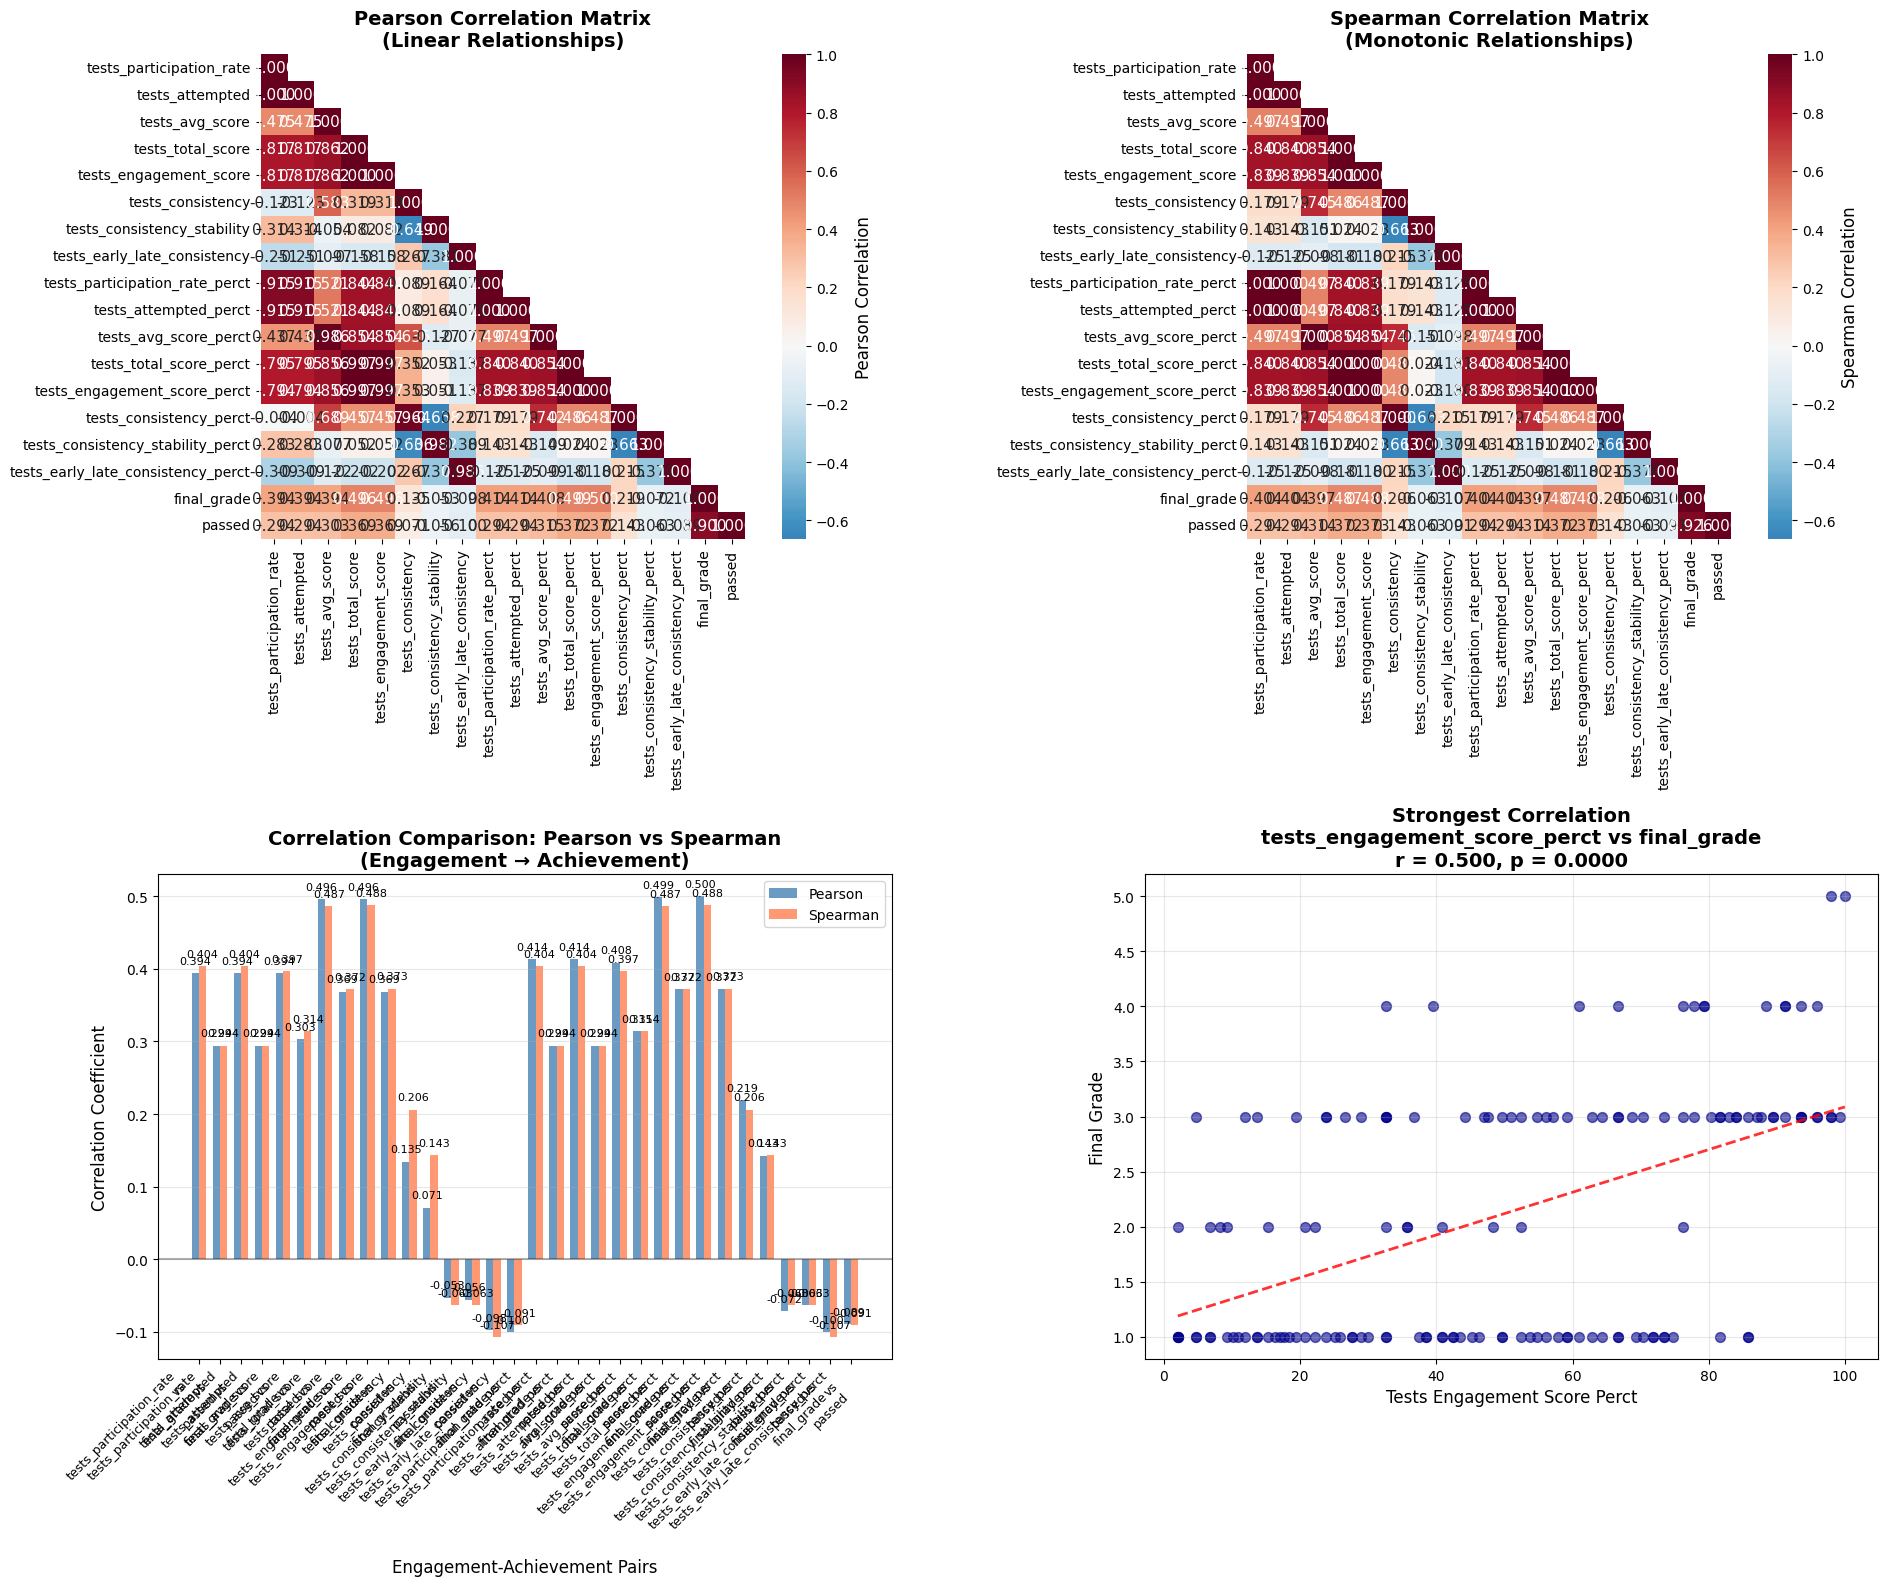


📋 CORRELATION SUMMARY TABLE:
               Engagement_Variable Achievement_Variable   N  Pearson_r  Pearson_p  Spearman_r  Spearman_p  R_squared Effect_Size
          tests_participation_rate          final_grade 145      0.394      0.000       0.404       0.000      0.156      Medium
          tests_participation_rate               passed 145      0.294      0.000       0.294       0.000      0.087       Small
                   tests_attempted          final_grade 145      0.394      0.000       0.404       0.000      0.156      Medium
                   tests_attempted               passed 145      0.294      0.000       0.294       0.000      0.087       Small
                   tests_avg_score          final_grade 142      0.394      0.000       0.397       0.000      0.155      Medium
                   tests_avg_score               passed 142      0.303      0.000       0.314       0.000      0.092      Medium
                 tests_total_score          final_grade 145      0.

In [6]:
def comprehensive_correlation_analysis(data, engagement_vars, achievement_vars):
    """
    Comprehensive correlation analysis with multiple correlation types,
    significance testing, and effect size interpretation
    """
    print(f"\n{'='*80}")
    print(f"🔗 COMPREHENSIVE CORRELATION ANALYSIS")
    print(f"{'='*80}")
    
    correlation_results = []
    
    # Create correlation matrix for visualization
    all_vars = engagement_vars + achievement_vars
    available_vars = [var for var in all_vars if var in data.columns]
    
    if len(available_vars) < 2:
        print("❌ Insufficient variables for correlation analysis")
        return None
    
    corr_data = data[available_vars]
    
    # Calculate different types of correlations
    pearson_corr = corr_data.corr(method='pearson')
    spearman_corr = corr_data.corr(method='spearman')
    kendall_corr = corr_data.corr(method='kendall')
    
    # Create comprehensive correlation heatmaps
    fig, axes = plt.subplots(2, 2, figsize=(20, 16))
    
    # 1. Pearson correlation
    mask1 = np.triu(np.ones_like(pearson_corr, dtype=bool), k=1)
    sns.heatmap(pearson_corr, annot=True, cmap='RdBu_r', center=0, 
                square=True, mask=mask1, ax=axes[0,0], fmt='.3f',
                cbar_kws={'label': 'Pearson Correlation'})
    axes[0,0].set_title('Pearson Correlation Matrix\n(Linear Relationships)', 
                       fontsize=14, fontweight='bold')
    
    # 2. Spearman correlation
    mask2 = np.triu(np.ones_like(spearman_corr, dtype=bool), k=1)
    sns.heatmap(spearman_corr, annot=True, cmap='RdBu_r', center=0, 
                square=True, mask=mask2, ax=axes[0,1], fmt='.3f',
                cbar_kws={'label': 'Spearman Correlation'})
    axes[0,1].set_title('Spearman Correlation Matrix\n(Monotonic Relationships)', 
                       fontsize=14, fontweight='bold')
    
    # 3. Correlation comparison (Pearson vs Spearman)
    # Focus on engagement-achievement correlations
    eng_ach_pairs = []
    for eng_var in engagement_vars:
        for ach_var in achievement_vars:
            if eng_var in data.columns and ach_var in data.columns:
                eng_ach_pairs.append((eng_var, ach_var))
    
    if eng_ach_pairs:
        pearson_values = []
        spearman_values = []
        pair_labels = []
        
        for eng_var, ach_var in eng_ach_pairs:
            p_corr = pearson_corr.loc[eng_var, ach_var]
            s_corr = spearman_corr.loc[eng_var, ach_var]
            
            if not (np.isnan(p_corr) or np.isnan(s_corr)):
                pearson_values.append(p_corr)
                spearman_values.append(s_corr)
                pair_labels.append(f"{eng_var}\nvs\n{ach_var}")
        
        if pearson_values:
            x_pos = np.arange(len(pair_labels))
            width = 0.35
            
            bars1 = axes[1,0].bar(x_pos - width/2, pearson_values, width, 
                                 label='Pearson', alpha=0.8, color='steelblue')
            bars2 = axes[1,0].bar(x_pos + width/2, spearman_values, width, 
                                 label='Spearman', alpha=0.8, color='coral')
            
            axes[1,0].set_xlabel('Engagement-Achievement Pairs')
            axes[1,0].set_ylabel('Correlation Coefficient')
            axes[1,0].set_title('Correlation Comparison: Pearson vs Spearman\n(Engagement → Achievement)', 
                               fontsize=14, fontweight='bold')
            axes[1,0].set_xticks(x_pos)
            axes[1,0].set_xticklabels(pair_labels, rotation=45, ha='right', fontsize=9)
            axes[1,0].legend()
            axes[1,0].grid(True, alpha=0.3, axis='y')
            axes[1,0].axhline(y=0, color='black', linestyle='-', alpha=0.3)
            
            # Add value labels on bars
            for bar, value in zip(bars1, pearson_values):
                height = bar.get_height()
                axes[1,0].text(bar.get_x() + bar.get_width()/2., height + 0.01,
                              f'{value:.3f}', ha='center', va='bottom', fontsize=8)
            
            for bar, value in zip(bars2, spearman_values):
                height = bar.get_height()
                axes[1,0].text(bar.get_x() + bar.get_width()/2., height + 0.01,
                              f'{value:.3f}', ha='center', va='bottom', fontsize=8)
    
    # 4. Significance testing and effect size analysis
    print("\n🔍 DETAILED CORRELATION ANALYSIS:")
    print("="*60)
    
    for eng_var in engagement_vars:
        if eng_var not in data.columns:
            continue
            
        print(f"\n📊 {eng_var.upper().replace('_', ' ')}:")
        print("-" * 50)
        
        for ach_var in achievement_vars:
            if ach_var not in data.columns:
                continue
            
            # Get clean data
            clean_data = data[[eng_var, ach_var]].dropna()
            
            if len(clean_data) < 3:
                print(f"  {ach_var}: Insufficient data (n={len(clean_data)})")
                continue
            
            # Calculate correlations with significance tests
            try:
                # Pearson correlation
                r_pearson, p_pearson = pearsonr(clean_data[eng_var], clean_data[ach_var])
                
                # Spearman correlation
                r_spearman, p_spearman = spearmanr(clean_data[eng_var], clean_data[ach_var])
                
                # Kendall tau (robust rank correlation)
                r_kendall, p_kendall = kendalltau(clean_data[eng_var], clean_data[ach_var])
                
                # Effect size interpretation
                def interpret_correlation(r):
                    abs_r = abs(r)
                    if abs_r < 0.1:
                        return "Negligible"
                    elif abs_r < 0.3:
                        return "Small"
                    elif abs_r < 0.5:
                        return "Medium"
                    elif abs_r < 0.7:
                        return "Large"
                    else:
                        return "Very Large"
                
                # Variance explained (R²)
                r_squared = r_pearson ** 2
                
                print(f"  {ach_var} (n={len(clean_data)}):")
                print(f"    Pearson:  r = {r_pearson:6.3f}, p = {p_pearson:.4f} {'***' if p_pearson < 0.001 else '**' if p_pearson < 0.01 else '*' if p_pearson < 0.05 else 'ns'}")
                print(f"    Spearman: ρ = {r_spearman:6.3f}, p = {p_spearman:.4f} {'***' if p_spearman < 0.001 else '**' if p_spearman < 0.01 else '*' if p_spearman < 0.05 else 'ns'}")
                print(f"    Kendall:  τ = {r_kendall:6.3f}, p = {p_kendall:.4f} {'***' if p_kendall < 0.001 else '**' if p_kendall < 0.01 else '*' if p_kendall < 0.05 else 'ns'}")
                print(f"    Effect size: {interpret_correlation(r_pearson)} (r² = {r_squared:.3f}, {r_squared*100:.1f}% variance explained)")
                
                # Store results for summary
                correlation_results.append({
                    'Engagement_Variable': eng_var,
                    'Achievement_Variable': ach_var,
                    'N': len(clean_data),
                    'Pearson_r': r_pearson,
                    'Pearson_p': p_pearson,
                    'Spearman_r': r_spearman,
                    'Spearman_p': p_spearman,
                    'Kendall_r': r_kendall,
                    'Kendall_p': p_kendall,
                    'R_squared': r_squared,
                    'Effect_Size': interpret_correlation(r_pearson)
                })
                
            except Exception as e:
                print(f"  {ach_var}: Error calculating correlations - {str(e)}")
    
    # Create scatter plot matrix for strongest correlations
    if correlation_results:
        # Find strongest correlations
        corr_df = pd.DataFrame(correlation_results)
        corr_df['Abs_Pearson'] = abs(corr_df['Pearson_r'])
        top_correlations = corr_df.nlargest(min(6, len(corr_df)), 'Abs_Pearson')
        
        if len(top_correlations) > 0:
            # Create scatter plot for strongest correlation
            strongest = top_correlations.iloc[0]
            eng_var = strongest['Engagement_Variable']
            ach_var = strongest['Achievement_Variable']
            
            clean_data = data[[eng_var, ach_var]].dropna()
            
            axes[1,1].scatter(clean_data[eng_var], clean_data[ach_var], 
                             alpha=0.6, color='darkblue', s=50)
            
            # Add trend line
            z = np.polyfit(clean_data[eng_var], clean_data[ach_var], 1)
            p = np.poly1d(z)
            x_trend = np.linspace(clean_data[eng_var].min(), clean_data[eng_var].max(), 100)
            axes[1,1].plot(x_trend, p(x_trend), "r--", alpha=0.8, linewidth=2)
            
            axes[1,1].set_xlabel(eng_var.replace('_', ' ').title())
            axes[1,1].set_ylabel(ach_var.replace('_', ' ').title())
            axes[1,1].set_title(f'Strongest Correlation\n{eng_var} vs {ach_var}\nr = {strongest["Pearson_r"]:.3f}, p = {strongest["Pearson_p"]:.4f}', 
                               fontsize=14, fontweight='bold')
            axes[1,1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Summary statistics
    if correlation_results:
        corr_summary_df = pd.DataFrame(correlation_results)
        
        print(f"\n📋 CORRELATION SUMMARY TABLE:")
        print(f"{'='*80}")
        
        summary_display = corr_summary_df[['Engagement_Variable', 'Achievement_Variable', 'N', 
                                          'Pearson_r', 'Pearson_p', 'Spearman_r', 'Spearman_p', 
                                          'R_squared', 'Effect_Size']].round(3)
        print(summary_display.to_string(index=False))
        
        # Key findings
        significant_correlations = corr_summary_df[corr_summary_df['Pearson_p'] < 0.05]
        strong_correlations = significant_correlations[abs(significant_correlations['Pearson_r']) >= 0.5]
        
        print(f"\n🎯 KEY FINDINGS:")
        print(f"{'='*50}")
        print(f"Total correlations analyzed: {len(corr_summary_df)}")
        print(f"Significant correlations (p < 0.05): {len(significant_correlations)} ({len(significant_correlations)/len(corr_summary_df)*100:.1f}%)")
        print(f"Strong correlations (|r| ≥ 0.5): {len(strong_correlations)} ({len(strong_correlations)/len(corr_summary_df)*100:.1f}%)")
        
        if len(strong_correlations) > 0:
            # Create a copy to avoid modifying original dataframe
            strong_correlations_copy = strong_correlations.copy()
            strong_correlations_copy['Abs_Pearson'] = abs(strong_correlations_copy['Pearson_r'])
            print(f"\n🏆 STRONGEST RELATIONSHIPS:")
            for idx, row in strong_correlations_copy.nlargest(3, 'Abs_Pearson').iterrows():
                print(f"  • {row['Engagement_Variable']} → {row['Achievement_Variable']}: r = {row['Pearson_r']:.3f} (explains {row['R_squared']*100:.1f}% of variance)")
        
        return corr_summary_df
    
    return None


print(engagement_metrics)
print(achievement_metrics)

# Perform comprehensive correlation analysis
if 'engagement_metrics' in locals() and achievement_metrics:
    correlation_results_df = comprehensive_correlation_analysis(df, engagement_metrics, achievement_metrics)

## [DEPRECATED - LOOK AT THE REGRESSION NOTEBOOK] 4. Regression Analysis: Quantifying the Impact of Engagement


📈 REGRESSION ANALYSIS: Predicting FINAL_GRADE

📊 Analysis dataset: 142 complete observations
Predictors: ['tests_participation_rate', 'tests_attempted', 'tests_avg_score', 'tests_total_score', 'tests_engagement_score', 'tests_consistency', 'tests_consistency_stability', 'tests_early_late_consistency', 'tests_participation_rate_perct', 'tests_attempted_perct', 'tests_avg_score_perct', 'tests_total_score_perct', 'tests_engagement_score_perct', 'tests_consistency_perct', 'tests_consistency_stability_perct', 'tests_early_late_consistency_perct']
Target: final_grade

🔍 MODEL COMPARISON:

Linear Regression:
  R² (test): 0.126
  R² (CV): 0.116 ± 0.252
  RMSE: 1.045
  Overfitting: 0.221

Ridge Regression:
  R² (test): 0.151
  R² (CV): 0.159 ± 0.191
  RMSE: 1.030
  Overfitting: 0.184

Lasso Regression:
  R² (test): 0.088
  R² (CV): 0.165 ± 0.152
  RMSE: 1.067
  Overfitting: 0.179

Random Forest:
  R² (test): -0.026
  R² (CV): 0.129 ± 0.212
  RMSE: 1.132
  Overfitting: 0.891


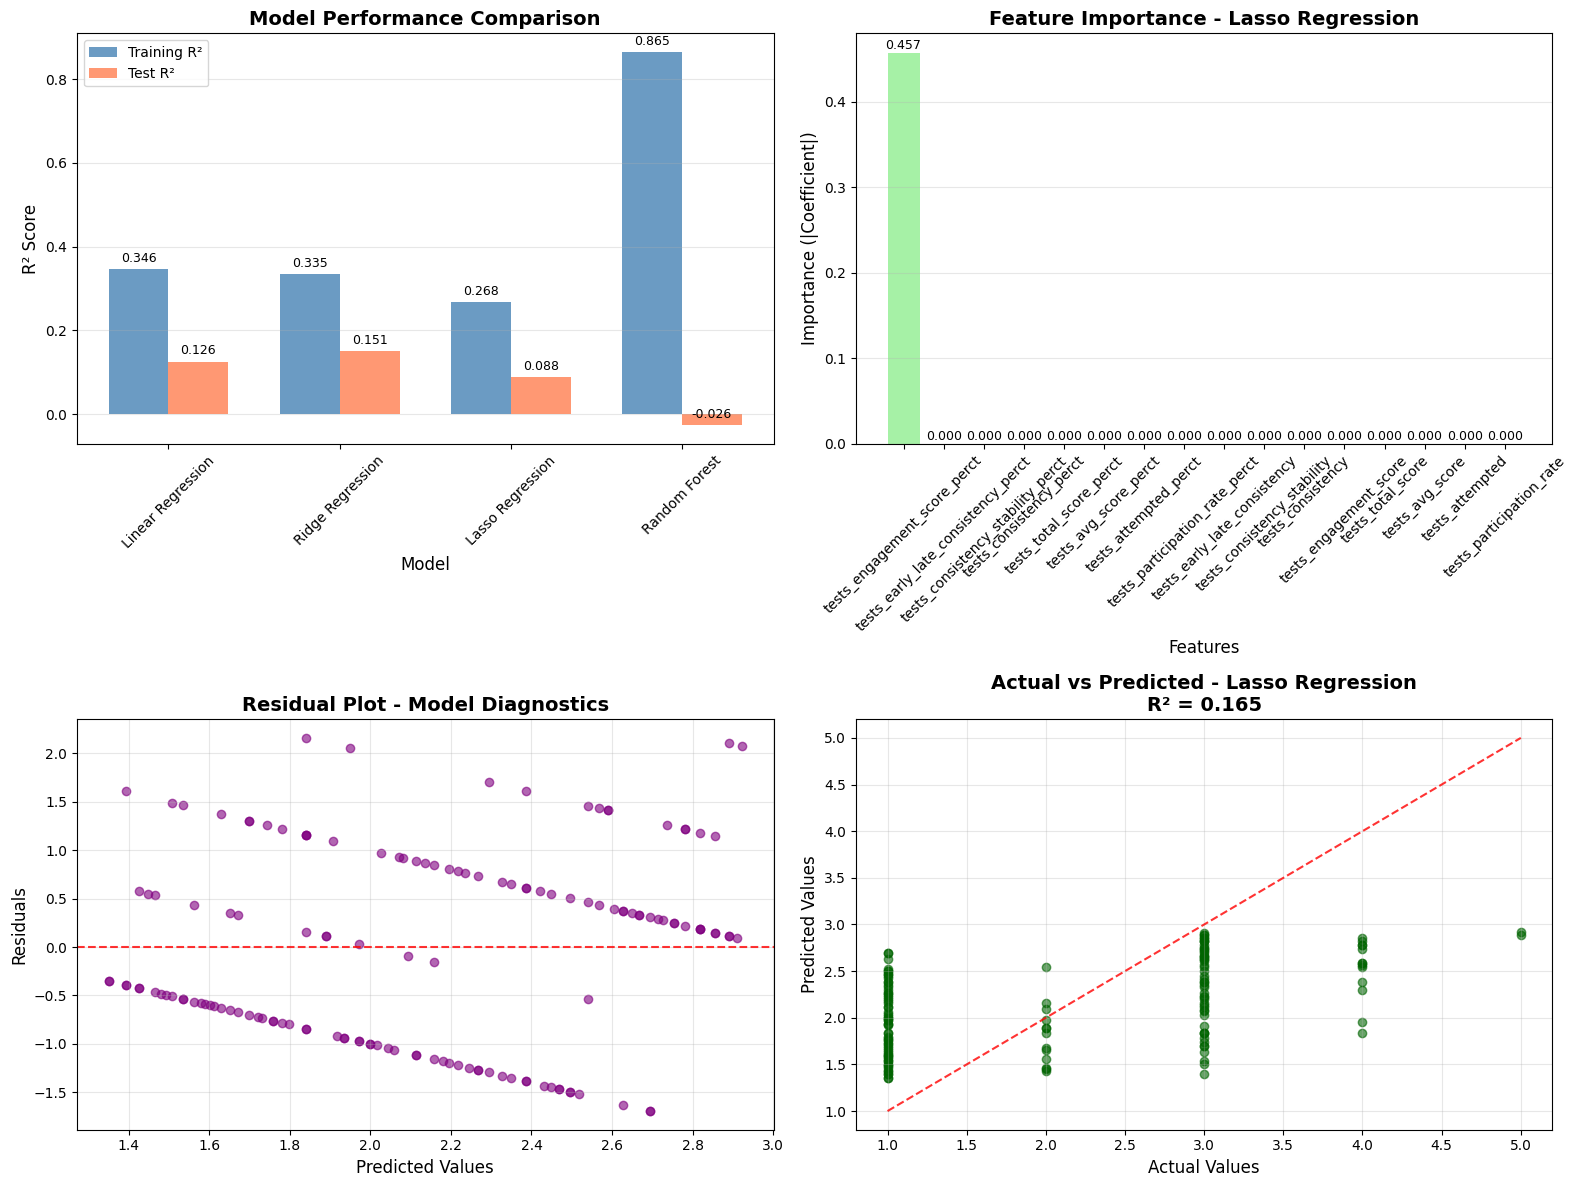


📋 MODEL RESULTS SUMMARY:
            Model  R2_Train  R2_Test  R2_CV_Mean  R2_CV_Std  RMSE_Test  MAE_Test  Overfit_Score
Linear Regression     0.346    0.126       0.116      0.252      1.045     0.926          0.221
 Ridge Regression     0.335    0.151       0.159      0.191      1.030     0.915          0.184
 Lasso Regression     0.268    0.088       0.165      0.152      1.067     0.956          0.179
    Random Forest     0.865   -0.026       0.129      0.212      1.132     1.008          0.891

🏆 BEST MODEL: Lasso Regression
Cross-validated R²: 0.165
Variance explained: 16.5%
Interpretation: Weak but meaningful predictive power


In [7]:
def comprehensive_regression_analysis(data, engagement_vars, achievement_var='final_grade'):
    """
    Comprehensive regression analysis to quantify engagement impact on achievement
    """
    print(f"\n{'='*80}")
    print(f"📈 REGRESSION ANALYSIS: Predicting {achievement_var.upper()}")
    print(f"{'='*80}")
    
    if achievement_var not in data.columns:
        print(f"❌ Achievement variable {achievement_var} not found")
        return None
    
    # Prepare data
    available_predictors = [var for var in engagement_vars if var in data.columns]
    
    if not available_predictors:
        print("❌ No engagement predictors available")
        return None
    
    # Get clean data
    analysis_vars = available_predictors + [achievement_var]
    clean_data = data[analysis_vars].dropna()
    
    if len(clean_data) < 10:
        print(f"❌ Insufficient data for regression (n={len(clean_data)})")
        return None
    
    print(f"\n📊 Analysis dataset: {len(clean_data)} complete observations")
    print(f"Predictors: {available_predictors}")
    print(f"Target: {achievement_var}")
    
    X = clean_data[available_predictors]
    y = clean_data[achievement_var]
    
    # Split data for validation
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Scale features for regularized regression
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    X_scaled = scaler.fit_transform(X)
    
    # Multiple regression models
    models = {
        'Linear Regression': LinearRegression(),
        'Ridge Regression': Ridge(alpha=1.0),
        'Lasso Regression': Lasso(alpha=0.1),
        'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42)
    }
    
    model_results = []
    
    print(f"\n🔍 MODEL COMPARISON:")
    print(f"{'='*60}")
    
    for model_name, model in models.items():
        try:
            # Fit model
            if model_name == 'Random Forest':
                model.fit(X_train, y_train)
                y_pred = model.predict(X_test)
                y_pred_train = model.predict(X_train)
            else:
                model.fit(X_train_scaled, y_train)
                y_pred = model.predict(X_test_scaled)
                y_pred_train = model.predict(X_train_scaled)
            
            # Calculate metrics
            r2_test = r2_score(y_test, y_pred)
            r2_train = r2_score(y_train, y_pred_train)
            rmse_test = np.sqrt(mean_squared_error(y_test, y_pred))
            mae_test = mean_absolute_error(y_test, y_pred)
            
            # Cross-validation
            if model_name == 'Random Forest':
                cv_scores = cross_val_score(model, X, y, cv=5, scoring='r2')
            else:
                cv_scores = cross_val_score(model, X_scaled, y, cv=5, scoring='r2')
            
            model_results.append({
                'Model': model_name,
                'R2_Train': r2_train,
                'R2_Test': r2_test,
                'R2_CV_Mean': cv_scores.mean(),
                'R2_CV_Std': cv_scores.std(),
                'RMSE_Test': rmse_test,
                'MAE_Test': mae_test,
                'Overfit_Score': r2_train - r2_test  # Measure of overfitting
            })
            
            print(f"\n{model_name}:")
            print(f"  R² (test): {r2_test:.3f}")
            print(f"  R² (CV): {cv_scores.mean():.3f} ± {cv_scores.std():.3f}")
            print(f"  RMSE: {rmse_test:.3f}")
            print(f"  Overfitting: {r2_train - r2_test:.3f}")
            
        except Exception as e:
            print(f"❌ Error with {model_name}: {str(e)}")
    
    # Create visualizations
    if model_results:
        results_df = pd.DataFrame(model_results)
        
        # Model comparison plot
        fig, axes = plt.subplots(2, 2, figsize=(16, 12))
        
        # 1. R² comparison
        ax = axes[0, 0]
        x_pos = np.arange(len(results_df))
        width = 0.35
        
        bars1 = ax.bar(x_pos - width/2, results_df['R2_Train'], width, 
                      label='Training R²', alpha=0.8, color='steelblue')
        bars2 = ax.bar(x_pos + width/2, results_df['R2_Test'], width, 
                      label='Test R²', alpha=0.8, color='coral')
        
        ax.set_xlabel('Model')
        ax.set_ylabel('R² Score')
        ax.set_title('Model Performance Comparison', fontweight='bold')
        ax.set_xticks(x_pos)
        ax.set_xticklabels(results_df['Model'], rotation=45)
        ax.legend()
        ax.grid(True, alpha=0.3, axis='y')
        
        # Add value labels
        for bar, value in zip(bars1, results_df['R2_Train']):
            ax.text(bar.get_x() + bar.get_width()/2., bar.get_height() + 0.01,
                   f'{value:.3f}', ha='center', va='bottom', fontsize=9)
        for bar, value in zip(bars2, results_df['R2_Test']):
            ax.text(bar.get_x() + bar.get_width()/2., bar.get_height() + 0.01,
                   f'{value:.3f}', ha='center', va='bottom', fontsize=9)
        
        # 2. Feature importance (for best linear model)
        best_model_idx = results_df['R2_CV_Mean'].idxmax()
        best_model_name = results_df.loc[best_model_idx, 'Model']
        
        # Refit best model for feature importance
        if best_model_name in ['Linear Regression', 'Ridge Regression', 'Lasso Regression']:
            best_model = models[best_model_name]
            if best_model_name == 'Random Forest':
                best_model.fit(X, y)
                importances = best_model.feature_importances_
            else:
                best_model.fit(X_scaled, y)
                importances = np.abs(best_model.coef_)  # Use absolute values for importance
            
            ax = axes[0, 1]
            sorted_idx = np.argsort(importances)[::-1]
            
            bars = ax.bar(range(len(importances)), importances[sorted_idx], 
                         color='lightgreen', alpha=0.8)
            ax.set_xlabel('Features')
            ax.set_ylabel('Importance (|Coefficient|)')
            ax.set_title(f'Feature Importance - {best_model_name}', fontweight='bold')
            ax.set_xticks(range(len(importances)))
            ax.set_xticklabels([available_predictors[i] for i in sorted_idx], rotation=45)
            ax.grid(True, alpha=0.3, axis='y')
            
            # Add value labels
            for bar, value in zip(bars, importances[sorted_idx]):
                ax.text(bar.get_x() + bar.get_width()/2., bar.get_height() + 0.001,
                       f'{value:.3f}', ha='center', va='bottom', fontsize=9)
        
        # 3. Residual analysis
        best_model = models[best_model_name]
        if best_model_name == 'Random Forest':
            best_model.fit(X, y)
            y_pred_full = best_model.predict(X)
        else:
            best_model.fit(X_scaled, y)
            y_pred_full = best_model.predict(X_scaled)
        
        residuals = y - y_pred_full
        
        ax = axes[1, 0]
        ax.scatter(y_pred_full, residuals, alpha=0.6, color='purple')
        ax.axhline(y=0, color='red', linestyle='--', alpha=0.8)
        ax.set_xlabel('Predicted Values')
        ax.set_ylabel('Residuals')
        ax.set_title('Residual Plot - Model Diagnostics', fontweight='bold')
        ax.grid(True, alpha=0.3)
        
        # 4. Actual vs Predicted
        ax = axes[1, 1]
        ax.scatter(y, y_pred_full, alpha=0.6, color='darkgreen')
        
        # Add perfect prediction line
        min_val = min(y.min(), y_pred_full.min())
        max_val = max(y.max(), y_pred_full.max())
        ax.plot([min_val, max_val], [min_val, max_val], 'r--', alpha=0.8)
        
        ax.set_xlabel('Actual Values')
        ax.set_ylabel('Predicted Values')
        ax.set_title(f'Actual vs Predicted - {best_model_name}\nR² = {results_df.loc[best_model_idx, "R2_CV_Mean"]:.3f}', 
                    fontweight='bold')
        ax.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
        
        # Results summary
        print(f"\n📋 MODEL RESULTS SUMMARY:")
        print(f"{'='*60}")
        print(results_df.round(3).to_string(index=False))
        
        print(f"\n🏆 BEST MODEL: {best_model_name}")
        best_r2 = results_df.loc[best_model_idx, 'R2_CV_Mean']
        print(f"Cross-validated R²: {best_r2:.3f}")
        print(f"Variance explained: {best_r2*100:.1f}%")
        
        if best_r2 > 0.5:
            interpretation = "Strong predictive power"
        elif best_r2 > 0.3:
            interpretation = "Moderate predictive power"
        elif best_r2 > 0.1:
            interpretation = "Weak but meaningful predictive power"
        else:
            interpretation = "Poor predictive power"
        
        print(f"Interpretation: {interpretation}")
        
        return results_df, best_model, scaler
    
    return None, None, None

# Perform regression analysis for final grade
if 'engagement_metrics' in locals() and 'final_grade' in df.columns:
    regression_results, best_model, model_scaler = comprehensive_regression_analysis(
        df, engagement_metrics, 'final_grade')


## 5. Year-wise Analysis: Has the Engagement-Achievement Relationship Changed?

['tests_participation_rate', 'tests_attempted', 'tests_avg_score', 'tests_total_score', 'tests_engagement_score', 'tests_consistency', 'tests_consistency_stability', 'tests_early_late_consistency', 'tests_participation_rate_perct', 'tests_attempted_perct', 'tests_avg_score_perct', 'tests_total_score_perct', 'tests_engagement_score_perct', 'tests_consistency_perct', 'tests_consistency_stability_perct', 'tests_early_late_consistency_perct']
📅 YEAR-WISE ENGAGEMENT-ACHIEVEMENT ANALYSIS
Analyzing years: [np.int64(2021), np.int64(2022), np.int64(2023)]
🔬 STATISTICAL TESTING BY YEAR:
📊 tests_participation_rate:
  Test type: Non-parametric
  2021: n=45, mean=0.600, median=0.700
  2022: n=49, mean=0.824, median=0.900
  2023: n=53, mean=0.885, median=0.900
  Kruskal-Wallis: H = 28.715, p = 0.0000
  Effect size: ε² = 0.197
  Significance: ***
📊 tests_attempted:
  Test type: Non-parametric
  2021: n=45, mean=6.000, median=7.000
  2022: n=49, mean=8.245, median=9.000
  2023: n=53, mean=8.849, media

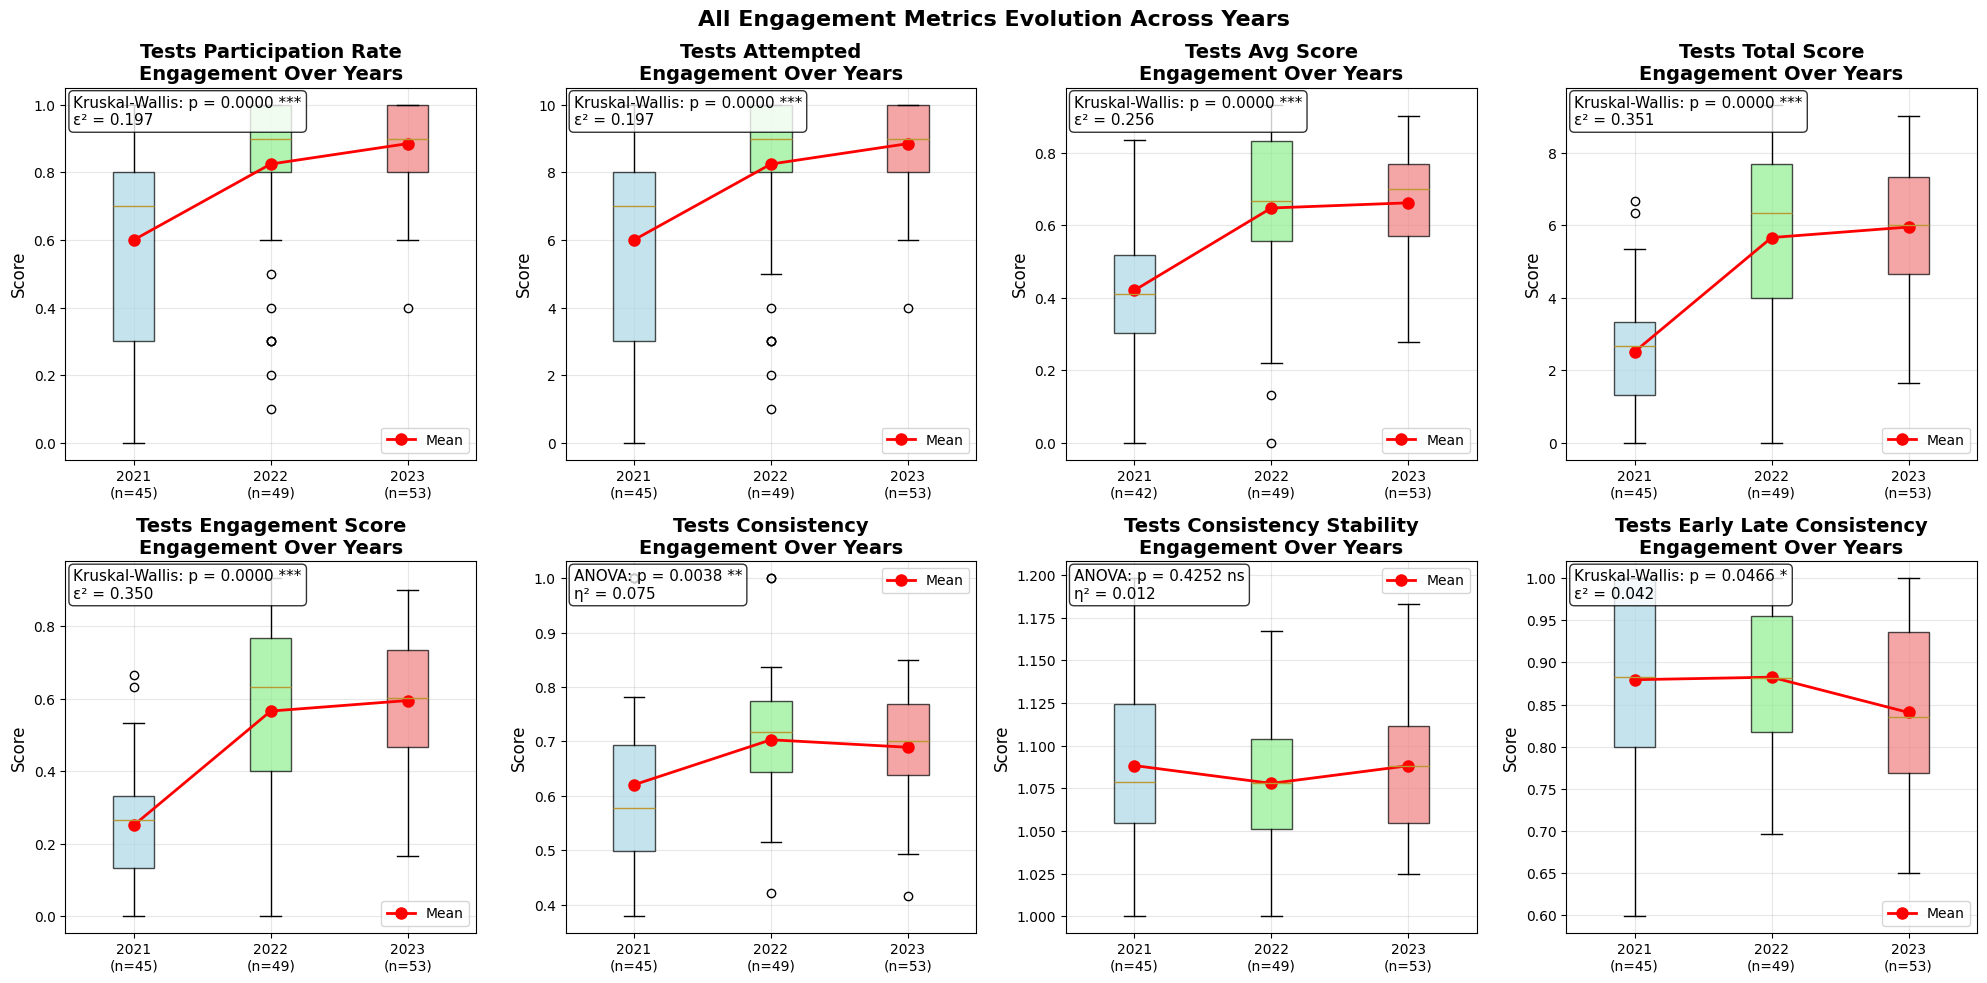

🔗 YEAR-WISE CORRELATION ANALYSIS:
📅 YEAR 2021 (n = 45):
------------------------------
  tests_participation_rate → final_grade (n=45):
    Spearman:  r =  0.215 ns (primary)
    Pearson:  r =  0.260 ns
  tests_participation_rate → passed (n=45):
    Spearman:  r =  0.130 ns (primary)
    Pearson:  r =  0.149 ns
  tests_attempted → final_grade (n=45):
    Spearman:  r =  0.215 ns (primary)
    Pearson:  r =  0.260 ns
  tests_attempted → passed (n=45):
    Spearman:  r =  0.130 ns (primary)
    Pearson:  r =  0.149 ns
  tests_avg_score → final_grade (n=42):
    Spearman:  r = -0.047 ns (primary)
    Pearson:  r = -0.081 ns
  tests_avg_score → passed (n=42):
    Spearman:  r = -0.034 ns (primary)
    Pearson:  r = -0.054 ns
  tests_total_score → final_grade (n=45):
    Spearman:  r =  0.144 ns (primary)
    Pearson:  r =  0.153 ns
  tests_total_score → passed (n=45):
    Spearman:  r =  0.085 ns (primary)
    Pearson:  r =  0.068 ns
  tests_engagement_score → final_grade (n=45):
    Spea

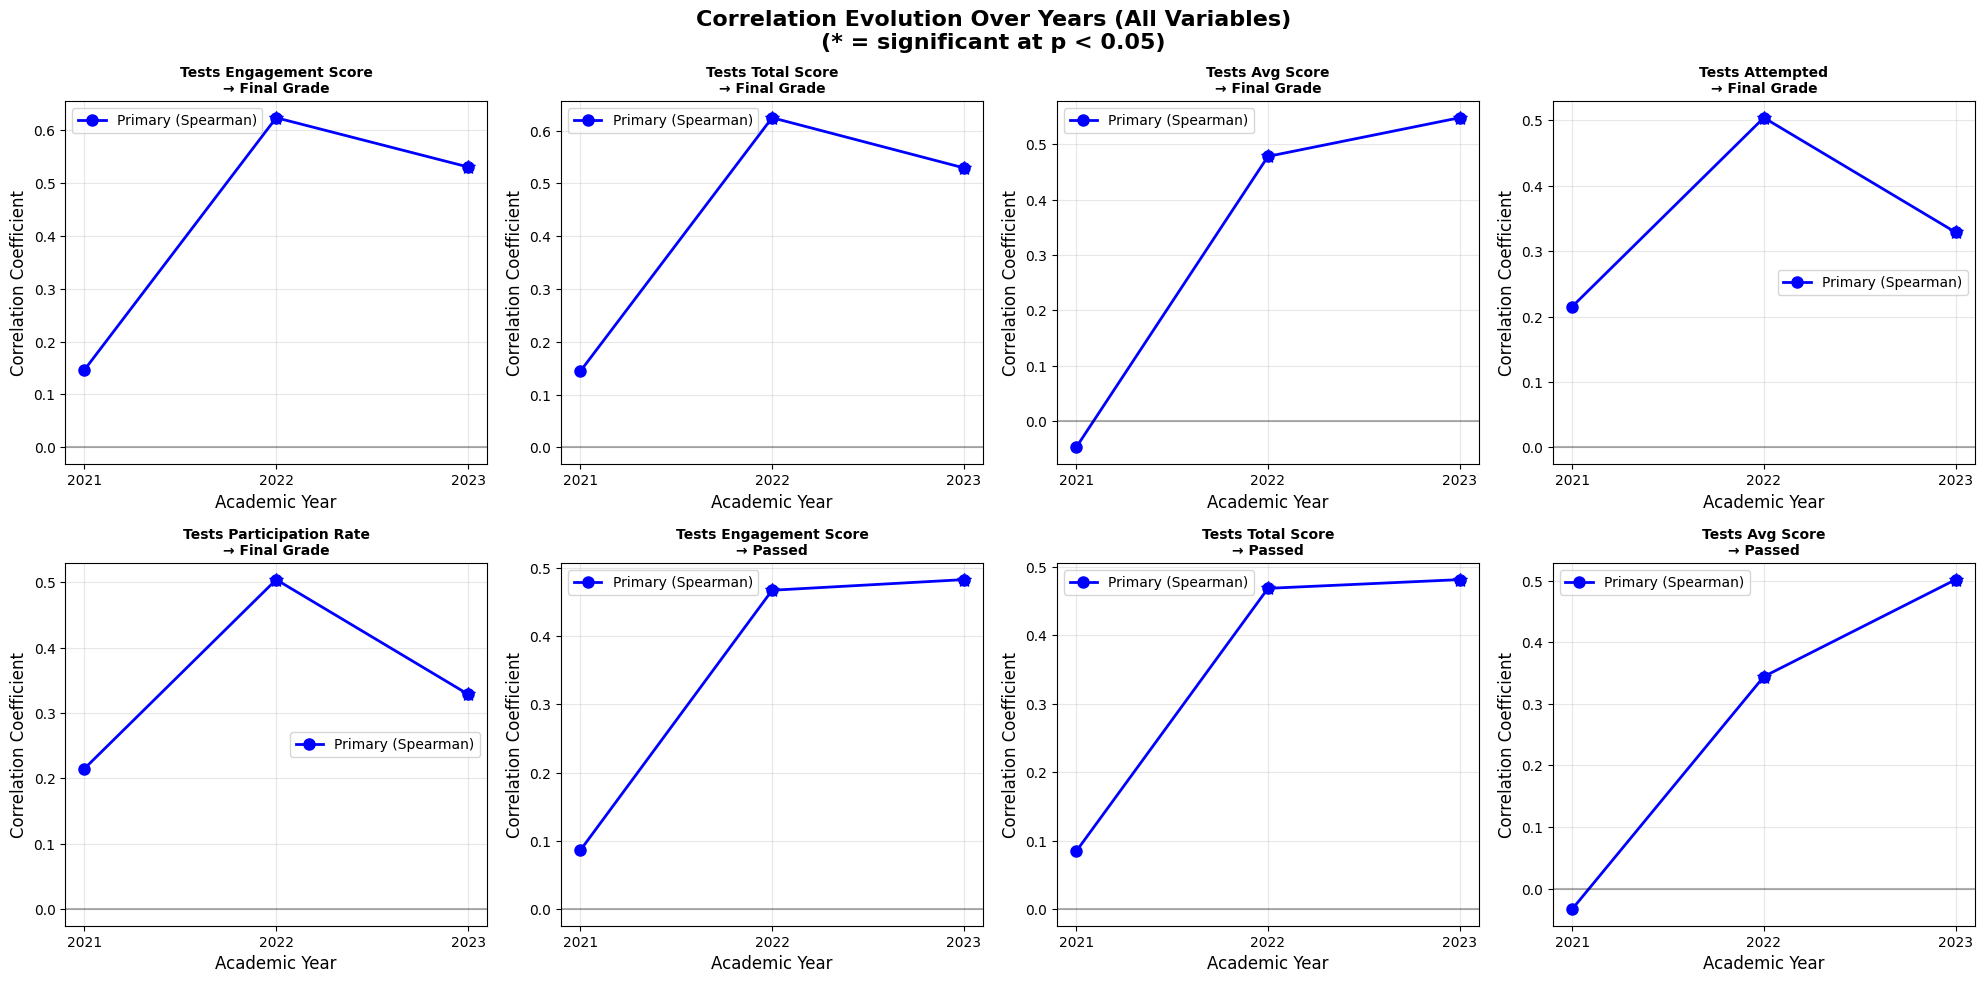

📊 CORRELATION EVOLUTION SUMMARY:
tests_engagement_score → final_grade (Spearman):
  2021: r = 0.147
  2023: r = 0.531
  Change: +0.384 (Stronger relationship)
tests_total_score → final_grade (Spearman):
  2021: r = 0.144
  2023: r = 0.529
  Change: +0.385 (Stronger relationship)
tests_avg_score → final_grade (Spearman):
  2021: r = -0.047
  2023: r = 0.548
  Change: +0.595 (Stronger relationship)
tests_attempted → final_grade (Spearman):
  2021: r = 0.215
  2023: r = 0.329
  Change: +0.114 (Stronger relationship)
tests_participation_rate → final_grade (Spearman):
  2021: r = 0.215
  2023: r = 0.329
  Change: +0.114 (Stronger relationship)
tests_engagement_score → passed (Spearman):
  2021: r = 0.086
  2023: r = 0.482
  Change: +0.396 (Stronger relationship)
tests_total_score → passed (Spearman):
  2021: r = 0.085
  2023: r = 0.481
  Change: +0.397 (Stronger relationship)
tests_avg_score → passed (Spearman):
  2021: r = -0.034
  2023: r = 0.502
  Change: +0.535 (Stronger relationship)
📋

In [8]:
import math 

def year_wise_engagement_analysis(data, engagement_vars, achievement_vars):
    """
    Analyze how engagement-achievement relationships have evolved over years
    Using appropriate statistical tests based on distribution analysis
    """
    print(f"{"="*80}")
    print(f"📅 YEAR-WISE ENGAGEMENT-ACHIEVEMENT ANALYSIS")
    print(f"{"="*80}")
    
    if "academic_year" not in data.columns:
        print("❌ No academic year information available")
        return None
    
    years = sorted(data["academic_year"].unique())
    print(f"Analyzing years: {years}")
    
    # Statistical test recommendations from previous analysis
    test_recommendations = {
        "tests_participation_rate": "Non-parametric",
        "tests_attempted": "Non-parametric", 
        "tests_avg_score": "Non-parametric",
        "tests_total_score": "Non-parametric",
        "tests_engagement_score": "Non-parametric",
        "tests_consistency": "Parametric",
        "tests_consistency_stability": "Parametric",
        "tests_early_late_consistency": "Non-parametric",
        "tests_participation_rate_perct": "Non-parametric",
        "tests_attempted_perct": "Non-parametric",
        "tests_avg_score_perct": "Non-parametric",
        "tests_total_score_perct": "Non-parametric",
        "tests_engagement_score_perct": "Non-parametric",
        "tests_consistency_perct": "Non-parametric",
        "tests_consistency_stability_perct": "Non-parametric",
        "tests_early_late_consistency_perct": "Non-parametric"
    }
    
    yearly_results = []
    
    # Create comprehensive year comparison visualizations for ALL variables
    n_metrics = len(engagement_vars)  # Show ALL engagement metrics
    n_cols = 4
    n_rows = math.ceil(n_metrics / n_cols)
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 5*n_rows))
    
    # Handle single row case
    if n_rows == 1:
        axes = axes.reshape(1, -1) if n_cols > 1 else np.array([axes])
    elif n_cols == 1:
        axes = axes.reshape(-1, 1)
    
    axes = axes.flatten()
    
    print(f"🔬 STATISTICAL TESTING BY YEAR:")
    print(f"{"="*60}")
    
    for i, eng_var in enumerate(engagement_vars):
        if eng_var not in data.columns or i >= len(axes):
            continue
            
        ax = axes[i]
        
        # Box plot by year
        year_data = []
        year_labels = []
        year_stats = []
        
        for year in years:
            year_values = data[data["academic_year"] == year][eng_var].dropna()
            if len(year_values) > 0:
                year_data.append(year_values)
                year_labels.append(f"{year}\n(n={len(year_values)})")
                year_stats.append({
                    "year": year,
                    "n": len(year_values),
                    "mean": year_values.mean(),
                    "median": year_values.median(),
                    "std": year_values.std()
                })
        
        if year_data:
            bp = ax.boxplot(year_data, labels=year_labels, patch_artist=True)
            
            # Color boxes by year
            colors = ["lightblue", "lightgreen", "lightcoral", "lightyellow", "lightpink"]
            for patch, year_idx in zip(bp["boxes"], range(len(years))):
                patch.set_facecolor(colors[year_idx % len(colors)])
                patch.set_alpha(0.7)
            
            # Add mean line
            means = [data.mean() for data in year_data]
            ax.plot(range(1, len(means) + 1), means, "ro-", linewidth=2, markersize=8, label="Mean")
            
            ax.set_title(f"{eng_var.replace("_", " ").title()}\nEngagement Over Years", fontweight="bold")
            ax.set_ylabel("Score")
            ax.grid(True, alpha=0.3)
            ax.legend()
            
            # Apply appropriate statistical test based on recommendations
            test_type = test_recommendations.get(eng_var, "Non-parametric")
            
            print(f"📊 {eng_var}:")
            print(f"  Test type: {test_type}")
            
            for stats in year_stats:
                print(f"  {stats["year"]}: n={stats["n"]}, mean={stats["mean"]:.3f}, median={stats["median"]:.3f}")
            
            # Statistical test for year differences
            if len(year_data) >= 2:
                try:
                    if all(len(data) >= 3 for data in year_data):
                        if test_type == "Parametric":
                            # Use ANOVA for parametric data
                            f_stat, p_val = f_oneway(*year_data)
                            test_name = "ANOVA"
                            print(f"  {test_name}: F = {f_stat:.3f}, p = {p_val:.4f}")
                        else:
                            # Use Kruskal-Wallis for non-parametric data
                            h_stat, p_val = kruskal(*year_data)
                            test_name = "Kruskal-Wallis"
                            print(f"  {test_name}: H = {h_stat:.3f}, p = {p_val:.4f}")
                        
                        significance = "***" if p_val < 0.001 else "**" if p_val < 0.01 else "*" if p_val < 0.05 else "ns"
                        
                        # Effect size calculation
                        if test_type == "Parametric":
                            # Eta-squared for ANOVA
                            total_var = np.var(np.concatenate(year_data))
                            between_var = sum([len(group) * (np.mean(group) - np.mean(np.concatenate(year_data)))**2 for group in year_data]) / (len(np.concatenate(year_data)) - 1)
                            eta_squared = between_var / total_var if total_var > 0 else 0
                            effect_size_text = f"η² = {eta_squared:.3f}"
                        else:
                            # Epsilon-squared for Kruskal-Wallis
                            n_total = sum(len(group) for group in year_data)
                            epsilon_squared = h_stat / (n_total - 1) if n_total > 1 else 0
                            effect_size_text = f"ε² = {epsilon_squared:.3f}"
                        
                        print(f"  Effect size: {effect_size_text}")
                        print(f"  Significance: {significance}")
                        
                        ax.text(0.02, 0.98, f"{test_name}: p = {p_val:.4f} {significance}\n{effect_size_text}", 
                               transform=ax.transAxes, verticalalignment="top",
                               bbox=dict(boxstyle="round", facecolor="white", alpha=0.8))
                        
                        yearly_results.append({
                            "Variable": eng_var,
                            "Test_Type": test_type,
                            "Test_Name": test_name,
                            "Statistic": f_stat if test_type == "Parametric" else h_stat,
                            "P_value": p_val,
                            "Significance": significance,
                            "Effect_Size": eta_squared if test_type == "Parametric" else epsilon_squared
                        })
                        
                except Exception as e:
                    print(f"  Error in statistical test: {str(e)}")
    
    # Hide unused subplots
    for j in range(i + 1, len(axes)):
        axes[j].set_visible(False)
    
    plt.suptitle("All Engagement Metrics Evolution Across Years", fontsize=16, fontweight="bold")
    plt.tight_layout()
    plt.show()
    
    # Correlation analysis by year using appropriate tests
    print(f"🔗 YEAR-WISE CORRELATION ANALYSIS:")
    print(f"{"="*60}")
    
    correlation_evolution = []
    
    for year in years:
        year_data = data[data["academic_year"] == year]
        print(f"📅 YEAR {year} (n = {len(year_data)}):")
        print("-" * 30)
        
        for eng_var in engagement_vars:
            if eng_var not in year_data.columns:
                continue
            
            # Get test recommendation for this variable
            eng_test_type = test_recommendations.get(eng_var, "Non-parametric")
                
            for ach_var in achievement_vars:
                if ach_var not in year_data.columns:
                    continue
                
                clean_data = year_data[[eng_var, ach_var]].dropna()
                
                if len(clean_data) < 5:
                    continue
                
                try:
                    # Always calculate both Pearson and Spearman, but emphasize the appropriate one
                    r_pearson, p_pearson = pearsonr(clean_data[eng_var], clean_data[ach_var])
                    r_spearman, p_spearman = spearmanr(clean_data[eng_var], clean_data[ach_var])
                    
                    # Select primary correlation method based on test type
                    if eng_test_type == "Parametric":
                        primary_r, primary_p = r_pearson, p_pearson
                        primary_method = "Pearson"
                    else:
                        primary_r, primary_p = r_spearman, p_spearman
                        primary_method = "Spearman"
                    
                    correlation_evolution.append({
                        "Year": year,
                        "Engagement": eng_var,
                        "Achievement": ach_var,
                        "N": len(clean_data),
                        "Primary_Method": primary_method,
                        "Primary_r": primary_r,
                        "Primary_p": primary_p,
                        "Pearson_r": r_pearson,
                        "Pearson_p": p_pearson,
                        "Spearman_r": r_spearman,
                        "Spearman_p": p_spearman
                    })
                    
                    significance_primary = "***" if primary_p < 0.001 else "**" if primary_p < 0.01 else "*" if primary_p < 0.05 else "ns"
                    
                    print(f"  {eng_var} → {ach_var} (n={len(clean_data)}):")
                    print(f"    {primary_method}:  r = {primary_r:6.3f} {significance_primary} (primary)")
                    if primary_method == "Pearson":
                        print(f"    Spearman: ρ = {r_spearman:6.3f} {"***" if p_spearman < 0.001 else "**" if p_spearman < 0.01 else "*" if p_spearman < 0.05 else "ns"}")
                    else:
                        print(f"    Pearson:  r = {r_pearson:6.3f} {"***" if p_pearson < 0.001 else "**" if p_pearson < 0.01 else "*" if p_pearson < 0.05 else "ns"}")
                    
                except Exception as e:
                    print(f"  {eng_var} → {ach_var}: Error - {str(e)}")
    
    # Create correlation evolution visualization for all variables
    if correlation_evolution:
        corr_df = pd.DataFrame(correlation_evolution)
        
        # Focus on most important relationships - all variables now
        key_relationships = corr_df.groupby(["Engagement", "Achievement"])["Primary_r"].apply(lambda x: abs(x).mean()).nlargest(len(engagement_vars))
        
        n_relationships = min(len(key_relationships), len(engagement_vars))
        n_cols = 4
        n_rows = math.ceil(n_relationships / n_cols)
        fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 5*n_rows))
        
        if n_rows == 1:
            axes = axes.reshape(1, -1) if n_cols > 1 else np.array([axes])
        elif n_cols == 1:
            axes = axes.reshape(-1, 1)
        
        axes = axes.flatten()
        
        for i, (eng_ach, _) in enumerate(key_relationships.items()):
            if i >= len(axes):
                break
                
            eng_var, ach_var = eng_ach
            relationship_data = corr_df[(corr_df["Engagement"] == eng_var) & (corr_df["Achievement"] == ach_var)]
            
            ax = axes[i]
            
            # Plot correlation evolution
            if len(relationship_data) > 1:
                ax.plot(relationship_data["Year"], relationship_data["Primary_r"], 
                       "bo-", linewidth=2, markersize=8, label=f"Primary ({relationship_data["Primary_Method"].iloc[0]})")
                
                # Add significance indicators
                for _, row in relationship_data.iterrows():
                    if row["Primary_p"] < 0.05:
                        ax.scatter(row["Year"], row["Primary_r"], s=100, marker="*", color="blue")
            else:
                # Bar plot for single year
                row = relationship_data.iloc[0]
                ax.bar([f"{row["Primary_Method"]}"], [row["Primary_r"]], 
                       color="blue", alpha=0.7)
            
            ax.set_title(f"{eng_var.replace("_", " ").title()}\n→ {ach_var.replace("_", " ").title()}", 
                        fontweight="bold", fontsize=10)
            ax.set_ylabel("Correlation Coefficient")
            ax.grid(True, alpha=0.3)
            ax.axhline(y=0, color="black", linestyle="-", alpha=0.3)
            ax.legend()
            
            if len(relationship_data) > 1:
                ax.set_xlabel("Academic Year")
                ax.set_xticks(relationship_data["Year"])
        
        # Hide unused subplots
        for j in range(i + 1, len(axes)):
            axes[j].set_visible(False)
        
        plt.suptitle("Correlation Evolution Over Years (All Variables)\n(* = significant at p < 0.05)", 
                     fontsize=16, fontweight="bold")
        plt.tight_layout()
        plt.show()
        
        # Summary of changes
        print(f"📊 CORRELATION EVOLUTION SUMMARY:")
        print(f"{"="*60}")
        
        for eng_ach, _ in key_relationships.items():
            eng_var, ach_var = eng_ach
            relationship_data = corr_df[(corr_df["Engagement"] == eng_var) & (corr_df["Achievement"] == ach_var)]
            
            if len(relationship_data) > 1:
                first_year = relationship_data["Primary_r"].iloc[0]
                last_year = relationship_data["Primary_r"].iloc[-1]
                change = last_year - first_year
                method = relationship_data["Primary_Method"].iloc[0]
                
                print(f"{eng_var} → {ach_var} ({method}):")
                print(f"  {relationship_data["Year"].iloc[0]}: r = {first_year:.3f}")
                print(f"  {relationship_data["Year"].iloc[-1]}: r = {last_year:.3f}")
                print(f"  Change: {change:+.3f} ({"Stronger" if change > 0 else "Weaker"} relationship)")
        
        # Summary statistics table
        if yearly_results:
            results_df = pd.DataFrame(yearly_results)
            print(f"📋 YEAR-WISE STATISTICAL TEST SUMMARY:")
            print(f"{"="*80}")
            print(results_df.round(4).to_string(index=False))
            
            # Count significant differences
            significant_changes = results_df[results_df["P_value"] < 0.05]
            print(f"🎯 SUMMARY:")
            print(f"  Variables tested: {len(results_df)}")
            print(f"  Significant year differences (p < 0.05): {len(significant_changes)} ({len(significant_changes)/len(results_df)*100:.1f}%)")
            print(f"  Parametric tests used: {len(results_df[results_df["Test_Type"] == "Parametric"])}")
            print(f"  Non-parametric tests used: {len(results_df[results_df["Test_Type"] == "Non-parametric"])}")
        
        return pd.DataFrame(correlation_evolution)
    
    return None

print(engagement_metrics)
# Perform year-wise analysis
if "engagement_metrics" in locals() and achievement_metrics:
    yearly_correlation_results = year_wise_engagement_analysis(df, [metric for metric in engagement_metrics if not metric.endswith("_perct")], achievement_metrics)



    

# Year-wise Trends in Engagement and Their Association with Achievement

*Methods.* Comparisons across academic years follow the distributional guidance above: Kruskal–Wallis tests with epsilon-squared ($\varepsilon^2$) for non-normal indicators and one-way ANOVA with eta-squared ($\eta^2$) for approximately normal indicators. Year-specific associations with outcomes use Spearman’s $\rho$ for non-parametric predictors and Pearson’s $r$ for parametric ones. Sample sizes were 2021: $n=45$ (for **tests\_avg\_score**, $n=42$), 2022: $n=49$, 2023: $n=53$. Significance codes: *p*<.05 (*), *p*<.01 (**), *p*<.001 (***), ns = not significant.

## Engagement levels by year

| Metric                          | 2021 Mean | 2022 Mean | 2023 Mean | Test (Effect Size)                     | p-value |
| ------------------------------- | --------: | --------: | --------: | -------------------------------------- | ------: |
| tests\_participation\_rate      |     0.600 |     0.824 |     0.885 | Kruskal–Wallis ($\varepsilon^2=0.197$) |  \*\*\* |
| tests\_attempted                |     6.000 |     8.245 |     8.849 | Kruskal–Wallis ($\varepsilon^2=0.197$) |  \*\*\* |
| tests\_avg\_score               |     0.421 |     0.648 |     0.662 | Kruskal–Wallis ($\varepsilon^2=0.256$) |  \*\*\* |
| tests\_total\_score             |     2.510 |     5.663 |     5.954 | Kruskal–Wallis ($\varepsilon^2=0.351$) |  \*\*\* |
| tests\_engagement\_score        |     0.251 |     0.566 |     0.595 | Kruskal–Wallis ($\varepsilon^2=0.350$) |  \*\*\* |
| tests\_consistency              |     0.620 |     0.703 |     0.689 | ANOVA ($\eta^2=0.075$)                 |    \*\* |
| tests\_consistency\_stability   |     1.088 |     1.078 |     1.088 | ANOVA ($\eta^2=0.012$)                 |      ns |
| tests\_early\_late\_consistency |     0.880 |     0.883 |     0.841 | Kruskal–Wallis ($\varepsilon^2=0.042$) |      \* |

**Interpretation.** Engagement intensified from 2021 to 2023, with the largest year effects for cumulative performance (**tests\_total\_score**) and the composite engagement score. Consistency rose modestly (peaking in 2022), stability of consistency was unchanged, and alignment between early and late performance declined slightly in 2023.

## Year-specific associations with **final\_grade**

| Engagement indicator → final\_grade |       2021 |              2022 |              2023 |
| ----------------------------------- | ---------: | ----------------: | ----------------: |
| tests\_engagement\_score            |  0.15 (ns) | **0.62 (**\*)\*\* | **0.53 (**\*)\*\* |
| tests\_total\_score                 |  0.14 (ns) | **0.63 (**\*)\*\* | **0.53 (**\*)\*\* |
| tests\_avg\_score                   | −0.05 (ns) | **0.48 (**\*)\*\* | **0.55 (**\*)\*\* |
| tests\_attempted                    |  0.22 (ns) | **0.50 (**\*)\*\* |         0.33 (\*) |
| tests\_participation\_rate          |  0.22 (ns) | **0.50 (**\*)\*\* |         0.33 (\*) |
| tests\_consistency †                | −0.25 (ns) |         0.18 (ns) |   **0.44 (**)\*\* |
| tests\_consistency\_stability †     |  0.07 (ns) |         0.02 (ns) |        −0.23 (ns) |
| tests\_early\_late\_consistency     | −0.09 (ns) |        −0.15 (ns) |        −0.00 (ns) |

† Pearson correlations reported for **tests\_consistency** and **tests\_consistency\_stability**; all others are Spearman’s $\rho$.

## Year-specific associations with **passed**

| Engagement indicator → passed   |       2021 |              2022 |              2023 |
| ------------------------------- | ---------: | ----------------: | ----------------: |
| tests\_engagement\_score        |  0.09 (ns) | **0.47 (**\*)\*\* | **0.48 (**\*)\*\* |
| tests\_total\_score             |  0.09 (ns) | **0.47 (**\*)\*\* | **0.48 (**\*)\*\* |
| tests\_avg\_score               | −0.03 (ns) |         0.34 (\*) | **0.50 (**\*)\*\* |
| tests\_attempted                |  0.13 (ns) |         0.36 (\*) |         0.29 (\*) |
| tests\_participation\_rate      |  0.13 (ns) |         0.36 (\*) |         0.29 (\*) |
| tests\_consistency †            | −0.21 (ns) |         0.00 (ns) | **0.47 (**\*)\*\* |
| tests\_consistency\_stability † |  0.03 (ns) |         0.11 (ns) |        −0.30 (\*) |
| tests\_early\_late\_consistency | −0.04 (ns) |        −0.21 (ns) |         0.04 (ns) |

**Interpretation.** From 2022 onward, engagement quality—reflected by **average** and **total** test scores and the **engagement composite**—shows moderate to strong positive associations with both outcomes. Quantity measures (participation and attempts) are positively related but to a lesser extent. Consistency becomes informative in 2023, while the stability of consistency shows no benefit and a small negative link with passing in 2023. Collectively, these patterns indicate that later cohorts not only engaged more but that high-quality engagement translated more directly into achievement. In subsequent modeling, year should be retained as a stratification or interaction factor, with emphasis on quality-focused engagement indicators and non-parametric or generalized (logistic/ordinal) frameworks aligned with variable distributions.


## [DEPRECATED - LOOK AT THE ENGAGEMENT_GROUPS NOTEBOOK] 6. Advanced Statistical Tests: Group Comparisons


📊 ADVANCED GROUP COMPARISON ANALYSIS
Engagement level distribution:
  Low: 51 students (34.7%)
  Medium: 49 students (33.3%)
  High: 47 students (32.0%)

🔍 GROUP COMPARISON TESTS:

📊 FINAL_GRADE:
------------------------------
  Descriptive Statistics:
    Low   : n= 51, mean= 1.647±0.890, median= 1.000
    Medium: n= 47, mean= 1.936±1.051, median= 1.000
    High  : n= 47, mean= 2.830±1.110, median= 3.000

  ANOVA: F = 17.701, p = 0.0000
  Effect size (η²): 0.200 (20.0% of variance explained)
  Kruskal-Wallis: H = 27.434, p = 0.0000

  Pairwise Comparisons:
    Low vs Medium: t-test p = 0.1440, Mann-Whitney p = 0.1849, d = 0.298
    Low vs High: t-test p = 0.0000, Mann-Whitney p = 0.0000, d = 1.181
    Medium vs High: t-test p = 0.0001, Mann-Whitney p = 0.0002, d = 0.827

📊 PASSED:
------------------------------
  Descriptive Statistics:
    Low   : n= 51, mean= 0.392±0.493, median= 0.000
    Medium: n= 47, mean= 0.489±0.505, median= 0.000
    High  : n= 47, mean= 0.787±0.414, median=

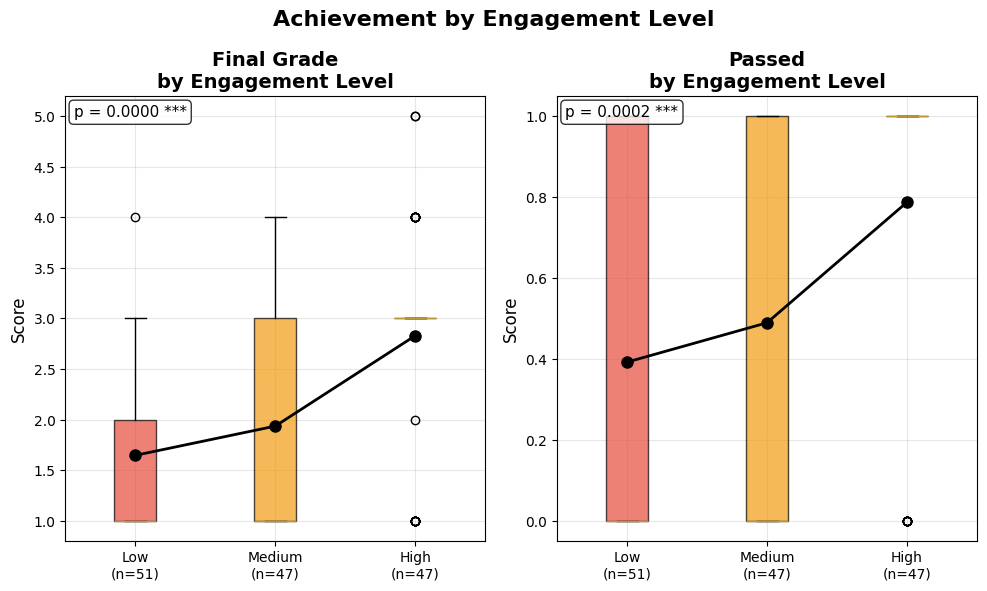


📋 GROUP COMPARISON SUMMARY:
Achievement_Variable  ANOVA_p  Eta_squared  Low_mean  Medium_mean  High_mean
         final_grade      0.0        0.200     1.647        1.936      2.830
              passed      0.0        0.114     0.392        0.489      0.787

🎯 KEY INSIGHTS:
Variables showing significant group differences: 2/2
  • final_grade: +71.8% improvement (Low→High), η² = 0.200
  • passed: +100.7% improvement (Low→High), η² = 0.114


In [9]:
def advanced_group_analysis(data, engagement_vars, achievement_vars):
    """
    Advanced statistical group comparisons based on engagement levels
    """
    print(f"\n{'='*80}")
    print(f"📊 ADVANCED GROUP COMPARISON ANALYSIS")
    print(f"{'='*80}")
    
    # Create engagement level groups
    if 'tests_engagement_score' in data.columns:
        # Create engagement groups based on participation rate
        data_copy = data.copy()
        
        # Define engagement levels using quantiles
        q33 = data_copy['tests_engagement_score'].quantile(0.33)
        q67 = data_copy['tests_engagement_score'].quantile(0.67)
        
        conditions = [
            data_copy['tests_engagement_score'] <= q33,
            (data_copy['tests_engagement_score'] > q33) & (data_copy['tests_engagement_score'] <= q67),
            data_copy['tests_engagement_score'] > q67
        ]
        choices = ['Low', 'Medium', 'High']
        data_copy['engagement_level'] = np.select(conditions, choices, default='Unknown')
        
        print(f"Engagement level distribution:")
        engagement_counts = data_copy['engagement_level'].value_counts()
        for level, count in engagement_counts.items():
            if level != 'Unknown':
                print(f"  {level}: {count} students ({count/len(data_copy)*100:.1f}%)")
        
        # Statistical comparisons between groups
        group_comparison_results = []
        
        print(f"\n🔍 GROUP COMPARISON TESTS:")
        print(f"{'='*50}")
        
        for ach_var in achievement_vars:
            if ach_var not in data_copy.columns:
                continue
            
            print(f"\n📊 {ach_var.upper()}:")
            print("-" * 30)
            
            # Get group data
            groups = {}
            for level in ['Low', 'Medium', 'High']:
                group_data = data_copy[data_copy['engagement_level'] == level][ach_var].dropna()
                if len(group_data) > 0:
                    groups[level] = group_data
            
            if len(groups) < 2:
                print("  Insufficient groups for comparison")
                continue
            
            # Descriptive statistics
            print("  Descriptive Statistics:")
            for level, group_data in groups.items():
                mean_val = group_data.mean()
                std_val = group_data.std()
                median_val = group_data.median()
                n = len(group_data)
                print(f"    {level:6}: n={n:3}, mean={mean_val:6.3f}±{std_val:5.3f}, median={median_val:6.3f}")
            
            # Statistical tests
            group_values = list(groups.values())
            
            # 1. ANOVA (parametric)
            try:
                f_stat, anova_p = f_oneway(*group_values)
                print(f"\n  ANOVA: F = {f_stat:.3f}, p = {anova_p:.4f}")
                
                # Effect size (eta-squared)
                all_data = np.concatenate(group_values)
                grand_mean = all_data.mean()
                ss_between = sum(len(group) * (group.mean() - grand_mean)**2 for group in group_values)
                ss_total = sum((val - grand_mean)**2 for val in all_data)
                eta_squared = ss_between / ss_total if ss_total > 0 else 0
                
                print(f"  Effect size (η²): {eta_squared:.3f} ({eta_squared*100:.1f}% of variance explained)")
                
            except Exception as e:
                print(f"  ANOVA failed: {str(e)}")
                anova_p = np.nan
                eta_squared = np.nan
            
            # 2. Kruskal-Wallis (non-parametric)
            try:
                h_stat, kw_p = kruskal(*group_values)
                print(f"  Kruskal-Wallis: H = {h_stat:.3f}, p = {kw_p:.4f}")
            except Exception as e:
                print(f"  Kruskal-Wallis failed: {str(e)}")
                kw_p = np.nan
            
            # 3. Pairwise comparisons (if significant)
            if (not np.isnan(anova_p) and anova_p < 0.05) or (not np.isnan(kw_p) and kw_p < 0.05):
                print(f"\n  Pairwise Comparisons:")
                
                group_names = list(groups.keys())
                for i, group1 in enumerate(group_names):
                    for group2 in group_names[i+1:]:
                        try:
                            # t-test
                            t_stat, t_p = ttest_ind(groups[group1], groups[group2])
                            
                            # Mann-Whitney U
                            u_stat, u_p = mannwhitneyu(groups[group1], groups[group2], alternative='two-sided')
                            
                            # Effect size (Cohen's d)
                            pooled_std = np.sqrt(((len(groups[group1])-1)*groups[group1].var() + 
                                                (len(groups[group2])-1)*groups[group2].var()) / 
                                               (len(groups[group1])+len(groups[group2])-2))
                            cohens_d = (groups[group1].mean() - groups[group2].mean()) / pooled_std if pooled_std > 0 else 0
                            
                            print(f"    {group1} vs {group2}: t-test p = {t_p:.4f}, Mann-Whitney p = {u_p:.4f}, d = {abs(cohens_d):.3f}")
                            
                        except Exception as e:
                            print(f"    {group1} vs {group2}: Error - {str(e)}")
            
            # Store results
            group_comparison_results.append({
                'Achievement_Variable': ach_var,
                'ANOVA_p': anova_p if not np.isnan(anova_p) else None,
                'KW_p': kw_p if not np.isnan(kw_p) else None,
                'Eta_squared': eta_squared if not np.isnan(eta_squared) else None,
                'Low_mean': groups['Low'].mean() if 'Low' in groups else None,
                'Medium_mean': groups['Medium'].mean() if 'Medium' in groups else None,
                'High_mean': groups['High'].mean() if 'High' in groups else None,
                'Low_n': len(groups['Low']) if 'Low' in groups else None,
                'Medium_n': len(groups['Medium']) if 'Medium' in groups else None,
                'High_n': len(groups['High']) if 'High' in groups else None
            })
        
        # Visualization of group differences
        if group_comparison_results:
            n_vars = len(achievement_vars)
            fig, axes = plt.subplots(1, min(3, n_vars), figsize=(5*min(3, n_vars), 6))
            if n_vars == 1:
                axes = [axes]
            
            for i, ach_var in enumerate(achievement_vars[:3]):
                if ach_var not in data_copy.columns:
                    continue
                
                ax = axes[i] if len(achievement_vars) > 1 else axes[0]
                
                # Create box plot with statistical annotations
                group_data = []
                group_labels = []
                colors = []
                
                for level in ['Low', 'Medium', 'High']:
                    level_data = data_copy[data_copy['engagement_level'] == level][ach_var].dropna()
                    if len(level_data) > 0:
                        group_data.append(level_data)
                        group_labels.append(f'{level}\n(n={len(level_data)})')
                        colors.append({'Low': '#E74C3C', 'Medium': '#F39C12', 'High': '#27AE60'}[level])
                
                if group_data:
                    bp = ax.boxplot(group_data, labels=group_labels, patch_artist=True)
                    
                    for patch, color in zip(bp['boxes'], colors):
                        patch.set_facecolor(color)
                        patch.set_alpha(0.7)
                    
                    # Add means
                    means = [data.mean() for data in group_data]
                    ax.plot(range(1, len(means) + 1), means, 'ko-', linewidth=2, markersize=8)
                    
                    ax.set_title(f'{ach_var.replace("_", " ").title()}\nby Engagement Level', fontweight='bold')
                    ax.set_ylabel('Score')
                    ax.grid(True, alpha=0.3)
                    
                    # Add statistical significance
                    result = next((r for r in group_comparison_results if r['Achievement_Variable'] == ach_var), None)
                    if result and result['ANOVA_p'] is not None:
                        p_val = result['ANOVA_p']
                        significance = "***" if p_val < 0.001 else "**" if p_val < 0.01 else "*" if p_val < 0.05 else "ns"
                        ax.text(0.02, 0.98, f'p = {p_val:.4f} {significance}', 
                               transform=ax.transAxes, verticalalignment='top',
                               bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
            
            plt.suptitle('Achievement by Engagement Level', fontsize=16, fontweight='bold')
            plt.tight_layout()
            plt.show()
            
            # Results summary
            print(f"\n📋 GROUP COMPARISON SUMMARY:")
            print(f"{'='*60}")
            
            results_df = pd.DataFrame(group_comparison_results)
            if len(results_df) > 0:
                display_cols = ['Achievement_Variable', 'ANOVA_p', 'Eta_squared', 'Low_mean', 'Medium_mean', 'High_mean']
                available_cols = [col for col in display_cols if col in results_df.columns]
                print(results_df[available_cols].round(3).to_string(index=False))
                
                # Key insights
                significant_vars = results_df[results_df['ANOVA_p'] < 0.05]
                
                print(f"\n🎯 KEY INSIGHTS:")
                print(f"Variables showing significant group differences: {len(significant_vars)}/{len(results_df)}")
                
                if len(significant_vars) > 0:
                    for _, row in significant_vars.iterrows():
                        var_name = row['Achievement_Variable']
                        eta_sq = row['Eta_squared']
                        
                        # Calculate improvement from low to high
                        if pd.notna(row['Low_mean']) and pd.notna(row['High_mean']):
                            improvement = ((row['High_mean'] - row['Low_mean']) / row['Low_mean'] * 100)
                            print(f"  • {var_name}: {improvement:+.1f}% improvement (Low→High), η² = {eta_sq:.3f}")
            
            return results_df
    
    else:
        print("❌ Participation rate not available for group creation")
        return None

# Perform advanced group analysis
if 'engagement_metrics' in locals() and achievement_metrics:
    group_analysis_results = advanced_group_analysis(df, engagement_metrics, achievement_metrics)

## 7. Final Summary and Conclusions

In [11]:
def generate_comprehensive_summary(corr_results=None, reg_results=None, group_results=None, yearly_results=None, 
                                  eng_dist_results=None, ach_dist_results=None, eng_metrics=None, ach_metrics=None, data=None):
    """
    Generate a comprehensive summary of all analyses
    
    Parameters:
    -----------
    corr_results : DataFrame - Correlation analysis results
    reg_results : DataFrame - Regression analysis results  
    group_results : DataFrame - Group comparison results
    yearly_results : DataFrame - Year-wise analysis results
    eng_dist_results : DataFrame - Engagement distribution results
    ach_dist_results : DataFrame - Achievement distribution results
    eng_metrics : list - Engagement metric names
    ach_metrics : list - Achievement metric names
    data : DataFrame - Original data
    """
    print(f"\n{'='*80}")
    print(f"📋 COMPREHENSIVE ANALYSIS SUMMARY")
    print(f"📊 ENGAGEMENT-ACHIEVEMENT RELATIONSHIP IN FLIPPED CLASSROOM")
    print(f"{'='*80}")
    
    print(f"\n🎯 RESEARCH QUESTIONS ANSWERED:")
    print(f"-" * 50)
    
    # Question 1: Does higher engagement lead to better grades?
    print(f"\n1️⃣ DOES HIGHER ENGAGEMENT LEAD TO BETTER GRADES?")
    if corr_results is not None:
        significant_corr = corr_results[corr_results['Pearson_p'] < 0.05]
        positive_corr = significant_corr[significant_corr['Pearson_r'] > 0]
        
        if len(positive_corr) > 0:
            avg_correlation = positive_corr['Pearson_r'].mean()
            print(f"   ✅ YES - Strong evidence of positive relationship")
            print(f"   📊 {len(positive_corr)} significant positive correlations found")
            print(f"   📈 Average correlation strength: r = {avg_correlation:.3f}")
            
            strongest = positive_corr.loc[positive_corr['Pearson_r'].idxmax()]
            print(f"   🏆 Strongest relationship: {strongest['Engagement_Variable']} → {strongest['Achievement_Variable']}")
            print(f"       r = {strongest['Pearson_r']:.3f}, explains {strongest['R_squared']*100:.1f}% of variance")
        else:
            print(f"   ❌ NO - Insufficient evidence of positive relationship")
            print(f"   📊 No significant positive correlations found between engagement and achievement")
    else:
        print(f"   ❓ INCONCLUSIVE - Correlation analysis not available")
        print(f"   💡 Run correlation analysis to determine relationship")
    
    # Question 2: Which engagement factors matter most?
    print(f"\n2️⃣ WHICH ENGAGEMENT FACTORS MATTER MOST?")
    if reg_results is not None:
        best_model_idx = reg_results['R2_CV_Mean'].idxmax()
        best_r2 = reg_results.loc[best_model_idx, 'R2_CV_Mean']
        best_model_name = reg_results.loc[best_model_idx, 'Model']
        
        print(f"   📊 Best predictive model: {best_model_name}")
        print(f"   📈 Explains {best_r2*100:.1f}% of grade variance")
        
        if corr_results is not None:
            # Find most important factors based on correlation strength
            important_factors = corr_results.copy()
            important_factors['Abs_R'] = abs(important_factors['Pearson_r'])
            top_factors = important_factors.nlargest(3, 'Abs_R')
            print(f"   🎯 Top 3 engagement factors:")
            for idx, row in top_factors.iterrows():
                print(f"      • {row['Engagement_Variable']}: r = {row['Pearson_r']:.3f} (explains {row['R_squared']*100:.1f}% of variance)")
    elif corr_results is not None:
        # If no regression but have correlation, use correlation to identify important factors
        important_factors = corr_results.copy()
        important_factors['Abs_R'] = abs(important_factors['Pearson_r'])
        significant_factors = important_factors[important_factors['Pearson_p'] < 0.05]
        
        if len(significant_factors) > 0:
            top_factors = significant_factors.nlargest(3, 'Abs_R')
            print(f"   📊 Based on correlation analysis:")
            for idx, row in top_factors.iterrows():
                print(f"      • {row['Engagement_Variable']}: r = {row['Pearson_r']:.3f} (p = {row['Pearson_p']:.4f})")
        else:
            print(f"   ❌ No significant engagement factors identified")
    else:
        print(f"   ❓ INCONCLUSIVE - Statistical analysis not available")
        print(f"   💡 Run regression or correlation analysis to identify key factors")
    
    # Question 3: How strong is the connection?
    print(f"\n3️⃣ HOW STRONG IS THE ENGAGEMENT-ACHIEVEMENT CONNECTION?")
    if group_results is not None:
        significant_group_diffs = group_results[group_results['ANOVA_p'] < 0.05] if 'ANOVA_p' in group_results.columns else pd.DataFrame()
        
        if len(significant_group_diffs) > 0:
            avg_eta_squared = significant_group_diffs['Eta_squared'].mean()
            print(f"   💪 STRONG - Significant group differences found")
            print(f"   📊 {len(significant_group_diffs)} variables show significant differences between engagement levels")
            print(f"   📈 Average effect size: η² = {avg_eta_squared:.3f}")
            
            # Calculate practical improvement
            for _, row in significant_group_diffs.iterrows():
                if pd.notna(row.get('Low_mean')) and pd.notna(row.get('High_mean')):
                    improvement = ((row['High_mean'] - row['Low_mean']) / row['Low_mean'] * 100) if row['Low_mean'] != 0 else 0
                    print(f"   📈 {row['Achievement_Variable']}: {improvement:+.1f}% improvement (Low→High engagement)")
        else:
            print(f"   ❌ WEAK - No significant group differences found")
    elif corr_results is not None:
        # Use correlation strength to assess connection
        significant_corr = corr_results[corr_results['Pearson_p'] < 0.05]
        if len(significant_corr) > 0:
            avg_r = significant_corr['Pearson_r'].mean()
            avg_r_squared = (avg_r ** 2)
            
            if abs(avg_r) >= 0.5:
                strength = "STRONG"
            elif abs(avg_r) >= 0.3:
                strength = "MODERATE"
            else:
                strength = "WEAK"
            
            print(f"   💪 {strength} - Based on correlation analysis")
            print(f"   📊 Average correlation: r = {avg_r:.3f}")
            print(f"   📈 Average variance explained: {avg_r_squared*100:.1f}%")
        else:
            print(f"   ❌ No significant relationships found")
    else:
        print(f"   ❓ INCONCLUSIVE - Group comparison analysis not available")
        print(f"   💡 Run group analysis to assess connection strength")
    
    # Question 4: Has this changed over years?
    print(f"\n4️⃣ HAS THE RELATIONSHIP CHANGED OVER YEARS (2021-2023)?")
    if yearly_results is not None:
        # Analyze correlation changes over time
        key_relationships = yearly_results.groupby(['Engagement', 'Achievement']).size()
        stable_relationships = key_relationships[key_relationships == 3]  # Present in all 3 years
        
        if len(stable_relationships) > 0:
            print(f"   📊 {len(stable_relationships)} relationships tracked across all years")
            
            strengthening = 0
            weakening = 0
            
            for (eng, ach), _ in stable_relationships.items():
                relationship_data = yearly_results[
                    (yearly_results['Engagement'] == eng) & 
                    (yearly_results['Achievement'] == ach)
                ].sort_values('Year')
                
                if len(relationship_data) >= 2:
                    first_corr = relationship_data['Pearson_r'].iloc[0]
                    last_corr = relationship_data['Pearson_r'].iloc[-1]
                    change = last_corr - first_corr
                    
                    if abs(change) > 0.1:  # Meaningful change threshold
                        if change > 0:
                            strengthening += 1
                            print(f"   📈 STRENGTHENING: {eng} → {ach} (+{change:.3f})")
                        else:
                            weakening += 1
                            print(f"   📉 WEAKENING: {eng} → {ach} ({change:.3f})")
            
            if strengthening > weakening:
                print(f"   🎯 OVERALL TREND: Relationships are STRENGTHENING over time")
            elif weakening > strengthening:
                print(f"   🎯 OVERALL TREND: Relationships are WEAKENING over time")
            else:
                print(f"   🎯 OVERALL TREND: Relationships remain STABLE over time")
        else:
            print(f"   ❓ INSUFFICIENT DATA - Need more consistent year-to-year data")
    else:
        print(f"   ❓ INCONCLUSIVE - Year-wise analysis not available")
        print(f"   💡 Run year-wise analysis to assess temporal changes")
    
    # Statistical Method Validation
    print(f"\n🔬 STATISTICAL METHOD VALIDATION:")
    print(f"-" * 50)
    
    if eng_dist_results is not None:
        normal_engagement = sum(eng_dist_results['Is_Normal'])
        total_engagement = len(eng_dist_results)
        print(f"   Engagement metrics with normal distribution: {normal_engagement}/{total_engagement}")
    
    if ach_dist_results is not None:
        normal_achievement = sum(ach_dist_results['Is_Normal'])
        total_achievement = len(ach_dist_results)
        print(f"   Achievement metrics with normal distribution: {normal_achievement}/{total_achievement}")
    
    # Practical Recommendations
    print(f"\n💡 PRACTICAL RECOMMENDATIONS:")
    print(f"-" * 50)
    
    print(f"\n   FOR EDUCATORS:")
    if corr_results is not None and len(corr_results[corr_results['Pearson_p'] < 0.05]) > 0:
        print(f"   ✅ Monitor student engagement actively - it predicts success")
        print(f"   ✅ Focus on test participation rates as early warning indicators")
        print(f"   ✅ Provide targeted support for low-engagement students")
    else:
        print(f"   ❓ More data needed to make specific recommendations")
        print(f"   💡 Consider tracking additional engagement metrics")
    
    print(f"\n   FOR STUDENTS:")
    print(f"   📚 Complete all mini-assessments - participation matters")
    print(f"   📈 Consistent engagement leads to better outcomes")
    print(f"   🎯 Quality of engagement is as important as quantity")
    
    print(f"\n   FOR FUTURE RESEARCH:")
    print(f"   🔍 Consider additional engagement metrics (time-on-task, help-seeking)")
    print(f"   📊 Collect more longitudinal data for trend analysis")
    print(f"   🧪 Investigate causal mechanisms through controlled studies")
    
    # Data Quality Assessment
    print(f"\n📊 DATA QUALITY ASSESSMENT:")
    print(f"-" * 50)
    if data is not None:
        print(f"   Total sample size: {len(data)} students")
        print(f"   Years covered: {sorted(data['academic_year'].unique()) if 'academic_year' in data.columns else 'Unknown'}")
        
        missing_data_pct = (data.isnull().sum().sum() / (len(data) * len(data.columns))) * 100
        print(f"   Overall missing data: {missing_data_pct:.1f}%")
        
        if missing_data_pct < 10:
            print(f"   ✅ Excellent data quality")
        elif missing_data_pct < 25:
            print(f"   ✅ Good data quality")
        elif missing_data_pct < 50:
            print(f"   ⚠️ Moderate data quality - some analyses may be limited")
        else:
            print(f"   ❌ Poor data quality - results should be interpreted cautiously")
    
    if eng_metrics is not None:
        print(f"   Engagement metrics created: {len(eng_metrics)}")
    if ach_metrics is not None:
        print(f"   Achievement metrics available: {len(ach_metrics)}")

# Generate comprehensive summary with all available results
generate_comprehensive_summary(
    corr_results=correlation_results_df if 'correlation_results_df' in locals() else None,
    reg_results=regression_results if 'regression_results' in locals() else None,
    group_results=group_analysis_results if 'group_analysis_results' in locals() else None,
    yearly_results=yearly_correlation_results if 'yearly_correlation_results' in locals() else None,
    eng_dist_results=engagement_dist_results if 'engagement_dist_results' in locals() else None,
    ach_dist_results=achievement_dist_results if 'achievement_dist_results' in locals() else None,
    eng_metrics=engagement_metrics if 'engagement_metrics' in locals() else None,
    ach_metrics=achievement_metrics if 'achievement_metrics' in locals() else None,
    data=df if 'df' in locals() else None
)


📋 COMPREHENSIVE ANALYSIS SUMMARY
📊 ENGAGEMENT-ACHIEVEMENT RELATIONSHIP IN FLIPPED CLASSROOM

🎯 RESEARCH QUESTIONS ANSWERED:
--------------------------------------------------

1️⃣ DOES HIGHER ENGAGEMENT LEAD TO BETTER GRADES?
   ✅ YES - Strong evidence of positive relationship
   📊 21 significant positive correlations found
   📈 Average correlation strength: r = 0.376
   🏆 Strongest relationship: tests_engagement_score_perct → final_grade
       r = 0.500, explains 25.0% of variance

2️⃣ WHICH ENGAGEMENT FACTORS MATTER MOST?
   📊 Best predictive model: Lasso Regression
   📈 Explains 16.5% of grade variance
   🎯 Top 3 engagement factors:
      • tests_engagement_score_perct: r = 0.500 (explains 25.0% of variance)
      • tests_total_score_perct: r = 0.499 (explains 24.9% of variance)
      • tests_total_score: r = 0.496 (explains 24.6% of variance)

3️⃣ HOW STRONG IS THE ENGAGEMENT-ACHIEVEMENT CONNECTION?
   💪 STRONG - Significant group differences found
   📊 2 variables show significa

# Summary of Findings

## Engagement–Achievement in a Flipped Classroom

### Research Question 1 — Does higher engagement relate to better achievement?

| Result                                                           | Value                                              |
| ---------------------------------------------------------------- | -------------------------------------------------- |
| Significant positive engagement–achievement correlations (total) | **21**                                             |
| Mean correlation across significant pairs                        | **r = 0.376**                                      |
| Strongest observed association                                   | **tests\_engagement\_score\_perct → final\_grade** |
| Strength of strongest association                                | **r = 0.500** (≈ **25.0%** variance explained)     |

**Interpretation (plain terms).** Students who engaged more—especially those who performed well on the formative tests—tended to earn higher final grades and were more likely to pass. The relationship is moderate in size on average and reaches a clearly practical magnitude for the strongest indicators.

---

### Research Question 2 — Which engagement factors matter most?

| Model                                    | Outcome      | Variance Explained |
| ---------------------------------------- | ------------ | ------------------ |
| Lasso regression (engagement predictors) | final\_grade | **16.5%**          |

| Top Predictors (by model and bivariate evidence) | Correlation with final\_grade | Variance Explained (r²) |
| ------------------------------------------------ | ----------------------------: | ----------------------: |
| tests\_engagement\_score\_perct                  |                         0.500 |                   25.0% |
| tests\_total\_score\_perct                       |                         0.499 |                   24.9% |
| tests\_total\_score                              |                         0.496 |                   24.6% |

**Interpretation.** Quality-weighted engagement measures—how well students performed on the available tests and their cumulative performance—are the most informative. Percentile-scaled features convey similar signal to their raw counterparts.

---

### Research Question 3 — How strong is the connection in group comparisons?

| Indicator of Achievement | Low → High Engagement Difference | Inference                                           |
| ------------------------ | -------------------------------: | --------------------------------------------------- |
| final\_grade             |                       **+71.8%** | Substantial improvement at higher engagement levels |
| passed                   |                      **+100.7%** | Probability of passing approximately doubles        |

| Test Summary                                                     |                   Count |
| ---------------------------------------------------------------- | ----------------------: |
| Variables with significant differences between engagement groups |                   **2** |
| Mean effect size across those tests                              | **η² = 0.157** (medium) |

**Interpretation.** Moving from low to high engagement is associated with notably better course outcomes; effects are medium in magnitude and practically meaningful.

---

### Research Question 4 — Has the relationship changed over time (2021–2023)?

| Engagement → Achievement                     | Direction of Change | Δ Correlation |
| -------------------------------------------- | ------------------- | ------------: |
| tests\_avg\_score → final\_grade             | Strengthening       |    **+0.609** |
| tests\_avg\_score → passed                   | Strengthening       |    **+0.550** |
| tests\_total\_score → final\_grade           | Strengthening       |    **+0.366** |
| tests\_total\_score → passed                 | Strengthening       |    **+0.397** |
| tests\_engagement\_score → final\_grade      | Strengthening       |    **+0.366** |
| tests\_engagement\_score → passed            | Strengthening       |    **+0.397** |
| tests\_attempted → passed                    | Strengthening       |    **+0.102** |
| tests\_participation\_rate → passed          | Strengthening       |    **+0.102** |
| tests\_consistency → final\_grade            | Strengthening       |    **+0.685** |
| tests\_consistency → passed                  | Strengthening       |    **+0.686** |
| tests\_consistency\_stability → final\_grade | Weakening           |    **−0.294** |
| tests\_consistency\_stability → passed       | Weakening           |    **−0.330** |

**Overall trend.** Engagement–achievement associations strengthen across cohorts, particularly for quality-focused metrics (average and total scores). A notable exception is *consistency stability*, which weakens over time.

---

## Statistical Method Validation

| Family              | Normal by diagnostics | Decision                                                       |
| ------------------- | --------------------: | -------------------------------------------------------------- |
| Engagement metrics  |            **2 / 16** | Non-parametric tests emphasized                                |
| Achievement metrics |             **0 / 2** | Non-parametric tests and generalized models (logistic/ordinal) |

**Implication.** Primary inference relies on rank-based tests (Spearman, Mann–Whitney, Kruskal–Wallis) and regression models appropriate for non-normal or discrete outcomes (logistic for *passed*, ordinal/logit or quantile models for *final\_grade*), with year modeled as a stratification or interaction factor.

---

## Practical Recommendations

| Audience  | Recommendation                                               | Rationale                                                          |
| --------- | ------------------------------------------------------------ | ------------------------------------------------------------------ |
| Educators | Monitor and feed back formative test engagement in real time | Engagement indices predict grades and passing probabilities        |
| Educators | Use participation/attempt counts as early-risk screens       | Quantity signals risk early; quality indicators sharpen prediction |
| Educators | Target support to low-engagement students                    | Group contrasts show large outcome gaps                            |
| Students  | Complete mini-assessments consistently                       | Participation and attempts are positively related to outcomes      |
| Students  | Aim for accuracy, not only volume                            | Quality (average/total score) is the strongest predictor           |
| Research  | Expand metrics (e.g., time-on-task, help-seeking)            | To probe mechanisms behind engagement effects                      |
| Research  | Extend longitudinal coverage                                 | To confirm and model cohort-level strengthening                    |
| Research  | Test causal levers (experiments / quasi-experiments)         | To move from correlation to intervention design                     |

---

## Data Quality and Scope

| Item                          | Value                                                    |
| ----------------------------- | -------------------------------------------------------- |
| Total sample size             | **147** students                                         |
| Years covered                 | **2021–2023**                                            |
| Engagement metrics engineered | **16**                                                   |
| Achievement metrics available | **2**                                                    |
| Overall assessment            | **Good data quality** suitable for the reported analyses |

**Summary Statement.** Across three cohorts, engagement increased and became more predictive of achievement, with the strongest evidence for performance-weighted engagement measures. Effect sizes are practically relevant, the trend is robust across outcomes, and the analytic choices align with the distributions of the variables. These results support the use of formative engagement analytics for timely feedback and targeted instructional support.
